# Analyses - scRNA-seq villus - Figure S5, S6

In [1]:
import numpy as np
import matplotlib.pyplot as pl
import scanpy as sc
import pandas as pd
import seaborn as sns
from scipy.sparse import csr_matrix
from matplotlib import rcParams

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.17.0 scipy==1.3.1 pandas==0.25.1 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [3]:
sc.set_figure_params(vector_friendly=True,color_map='viridis',dpi_save=300,transparent=True, frameon=False)

In [4]:
sc.settings.figdir='./figures'

## helper functions

In [5]:
def population_barplot(adata, 
                       obs_group, 
                       obs_hue, 
                       figsize=None, 
                       xlabel='', 
                       ylabel='% cells', 
                       xtickrotation=0, 
                       returnax=False,
                       save=False,
                       filename=None):
    df = adata.obs[[obs_group, obs_hue]]#[np.isin(adata.obs['clusters_fig3'],['Ngn3 high EP'])]
    d = df.groupby((obs_hue, obs_group)).size() / df.groupby((obs_hue)).size() *100
    #d.reset_index()
    if not figsize==None:
        rcParams['figure.figsize'] = figsize
    
    ax = sns.barplot(x=obs_group, y=0, hue=obs_hue, data=d.reset_index(),
                    palette=adata.uns[obs_hue+'_colors'])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=xtickrotation)
    ax.legend(loc=(1.05,0))
    if save:
        pl.savefig(filename, dpi=300)
    pl.show()
    if returnax:
        return ax
    

## Load processed data

In [15]:
adata = sc.read('./data/adata_villus_processed.h5ad')

In [116]:
adata

AnnData object with n_obs × n_vars = 4205 × 16697 
    obs: 'diet', 'mt_fraction', 'n_counts', 'n_genes', 'louvain', 'louvain_r', 'louvain_anno', 'density_diet'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'density_diet_params', 'diet_colors', 'louvain', 'louvain_anno_colors', 'louvain_r_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [16]:
### potential decoding needed
# for obs_key in ['diet', 'louvain', 'louvain_r', 'louvain_anno']:
#     adata.obs[obs_key] = [str(obs.decode('UTF-8')) for obs in adata.obs[obs_key]]
# adata.var_names = [str(obs.decode('UTF-8')) for obs in adata.var_names]
# adata.obs_names = [str(obs.decode('UTF-8')) for obs in adata.obs_names]
# for obs_key in ['louvain_r_colors', 'louvain_anno_colors', 'diet_colors']:
#     adata.uns[obs_key] = [str(obs.decode('UTF-8')) for obs in adata.uns[obs_key]]

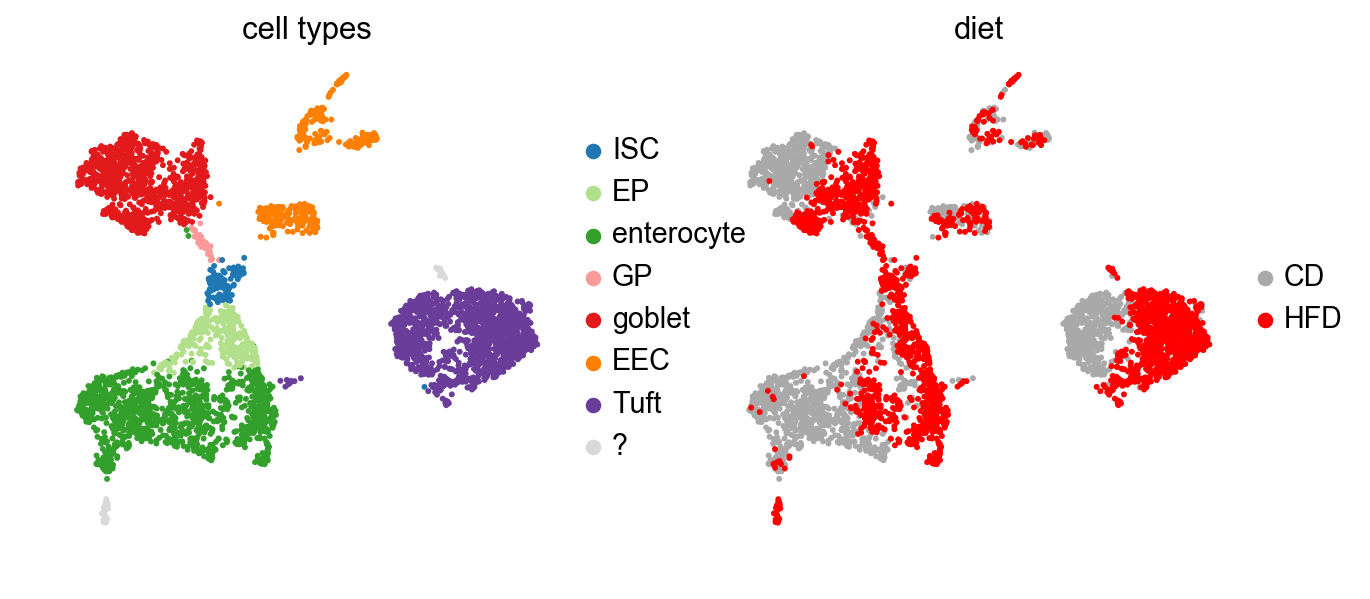

In [52]:
sc.pl.umap(adata, color=['louvain_anno', 'diet'], title=['cell types', 'diet'])

## Cell type composition

### Cell densities

In [51]:
sc.tl.embedding_density(adata, groupby='diet', basis='umap', key_added='density_diet')

computing density on 'umap'
--> added
    'density_diet', densities (adata.obs)
    'density_diet_params', parameter (adata.uns)


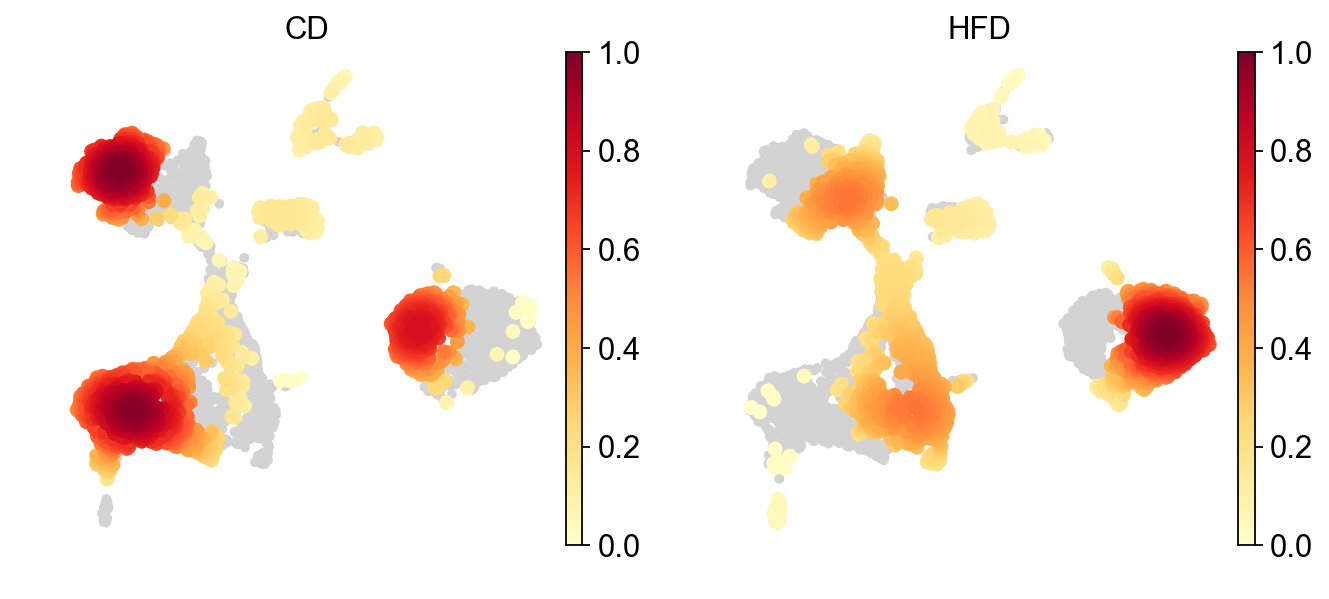

In [52]:
sc.pl.embedding_density(adata, key='density_diet', basis='umap')

### Cell type fractions

/Users/stritschler/code/miniconda3/envs/scanpy_14/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  # Remove the CWD from sys.path while we load stuff.


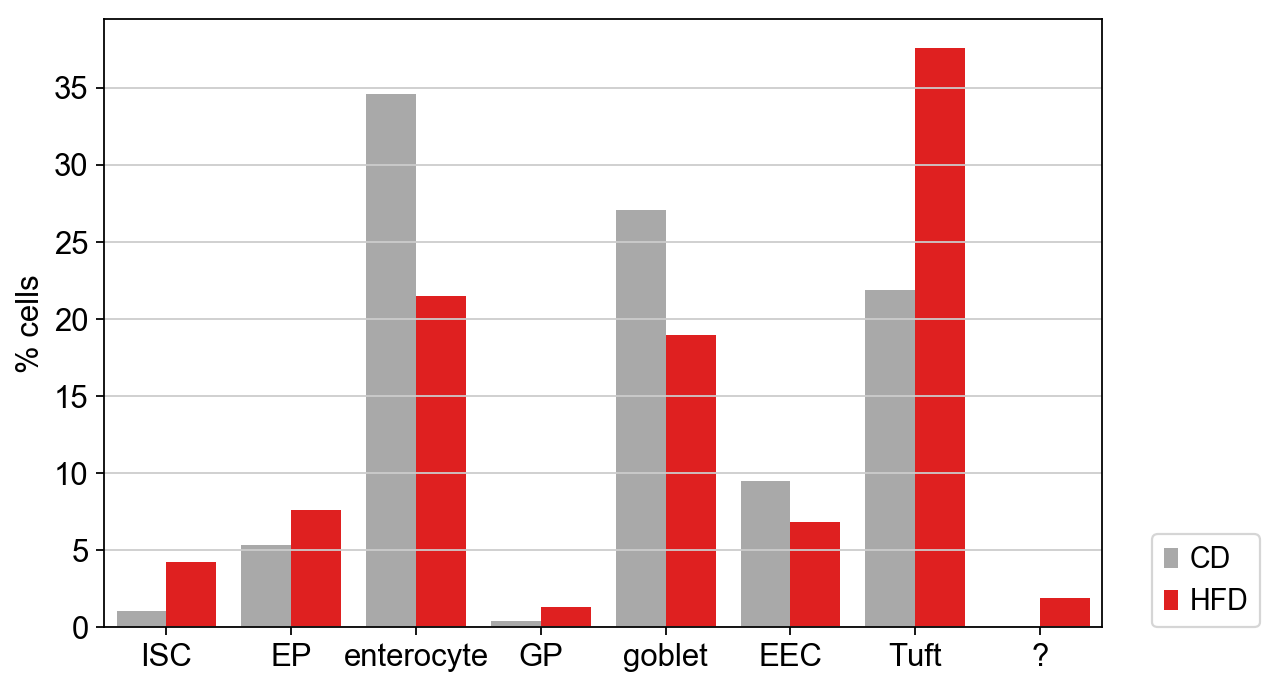

In [53]:
population_barplot(adata, 'louvain_anno', 'diet', figsize=(8,5))

## Enterocyte analyses

subset to enterocyte progenitors and enterocytes

In [9]:
adata_ent = adata[adata.obs.louvain_anno.isin(['enterocyte', 'EP'])].copy()

In [10]:
adata_ent.obs.louvain_anno.value_counts()

enterocyte    1164
EP             276
Name: louvain_anno, dtype: int64

In [11]:
pd.crosstab(adata_ent.obs.louvain_anno, adata_ent.obs.diet)

diet           CD  HFD
louvain_anno          
EP            106  170
enterocyte    685  479

### Regional cell scores

marker TFs for intestinal regions from Haber et al., 2017

In [13]:
haber_tf_dist = [
    'Klf6', 'Klf3', 'Atf3', 'Gata5', 'Foxo6', 'Jund', 'Zscan21', 'Relb', 
    'Zfp467', 'Hoxb7', 'Srebf2', 'Maf', 'Nfkb2', 'Cdx1', 'Srf', 'Zfp948', 
    'Bach1', 'Osr2', 'Nr1h4', 'Irf7', 'Zfp954', 'Mxd1', 'Fosl2', 'Klf4', 
    'E2f5', 'Hnf4a', 'Id1', 'Satb2', 'Pbx1', 'Ehf', 'Cdx2', 'Id2', 'Id3', 
    'Junb'
]

haber_tf_prox = [
    'Gata4', 'Prrx1', 'Sp5', 'Nr1i3', 'Zfpm1', 'Creb3', 'Onecut2', 'Creb3l3', 
    'Sp100', 'Creb3l2'
]

In [14]:
sc.tl.score_genes(adata_ent, gene_list=haber_tf_dist, score_name='haber_tf_dist')
sc.tl.score_genes(adata_ent, gene_list=haber_tf_prox, score_name='haber_tf_prox')

computing score 'haber_tf_dist'
    finished (0:00:00)
computing score 'haber_tf_prox'
    finished (0:00:00)


/Users/stritschler/code/miniconda3/envs/scanpy_14/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/stritschler/code/miniconda3/envs/scanpy_14/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/stritschler/code/miniconda3/envs/scanpy_14/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit

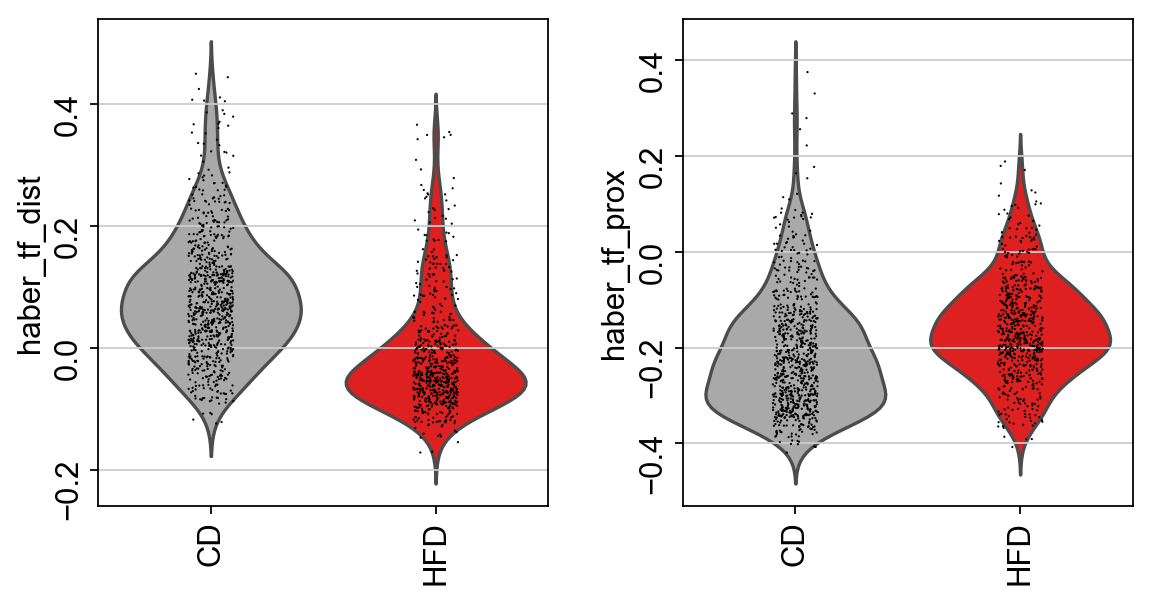

In [37]:
sc.settings.figdir = '/Users/stritschler/Documents/ICB/2020_HFD_villus/figures/slide_1/'
sc.pl.violin(adata_ent, groupby='diet', keys=['haber_tf_dist', 'haber_tf_prox'], 
             rotation=90, palette=adata_ent.uns['diet_colors'], save='_enterocytes_regionality_score_diet.pdf')

### Manifold and clustering in regional marker space

subset to regional marker TFs only

In [19]:
adata_ent_reg = adata_ent[:, [k for k in haber_tf_dist+haber_tf_prox if k in adata_ent.var_names]].copy()

compute kNN and manifold using regional marker TFs

In [20]:
sc.pp.neighbors(adata_ent_reg, use_rep='X', n_neighbors=10)

computing neighbors
    finished (0:00:02)


In [21]:
sc.tl.umap(adata_ent_reg)

computing UMAP
    finished (0:00:02)


regional cell scores and markers

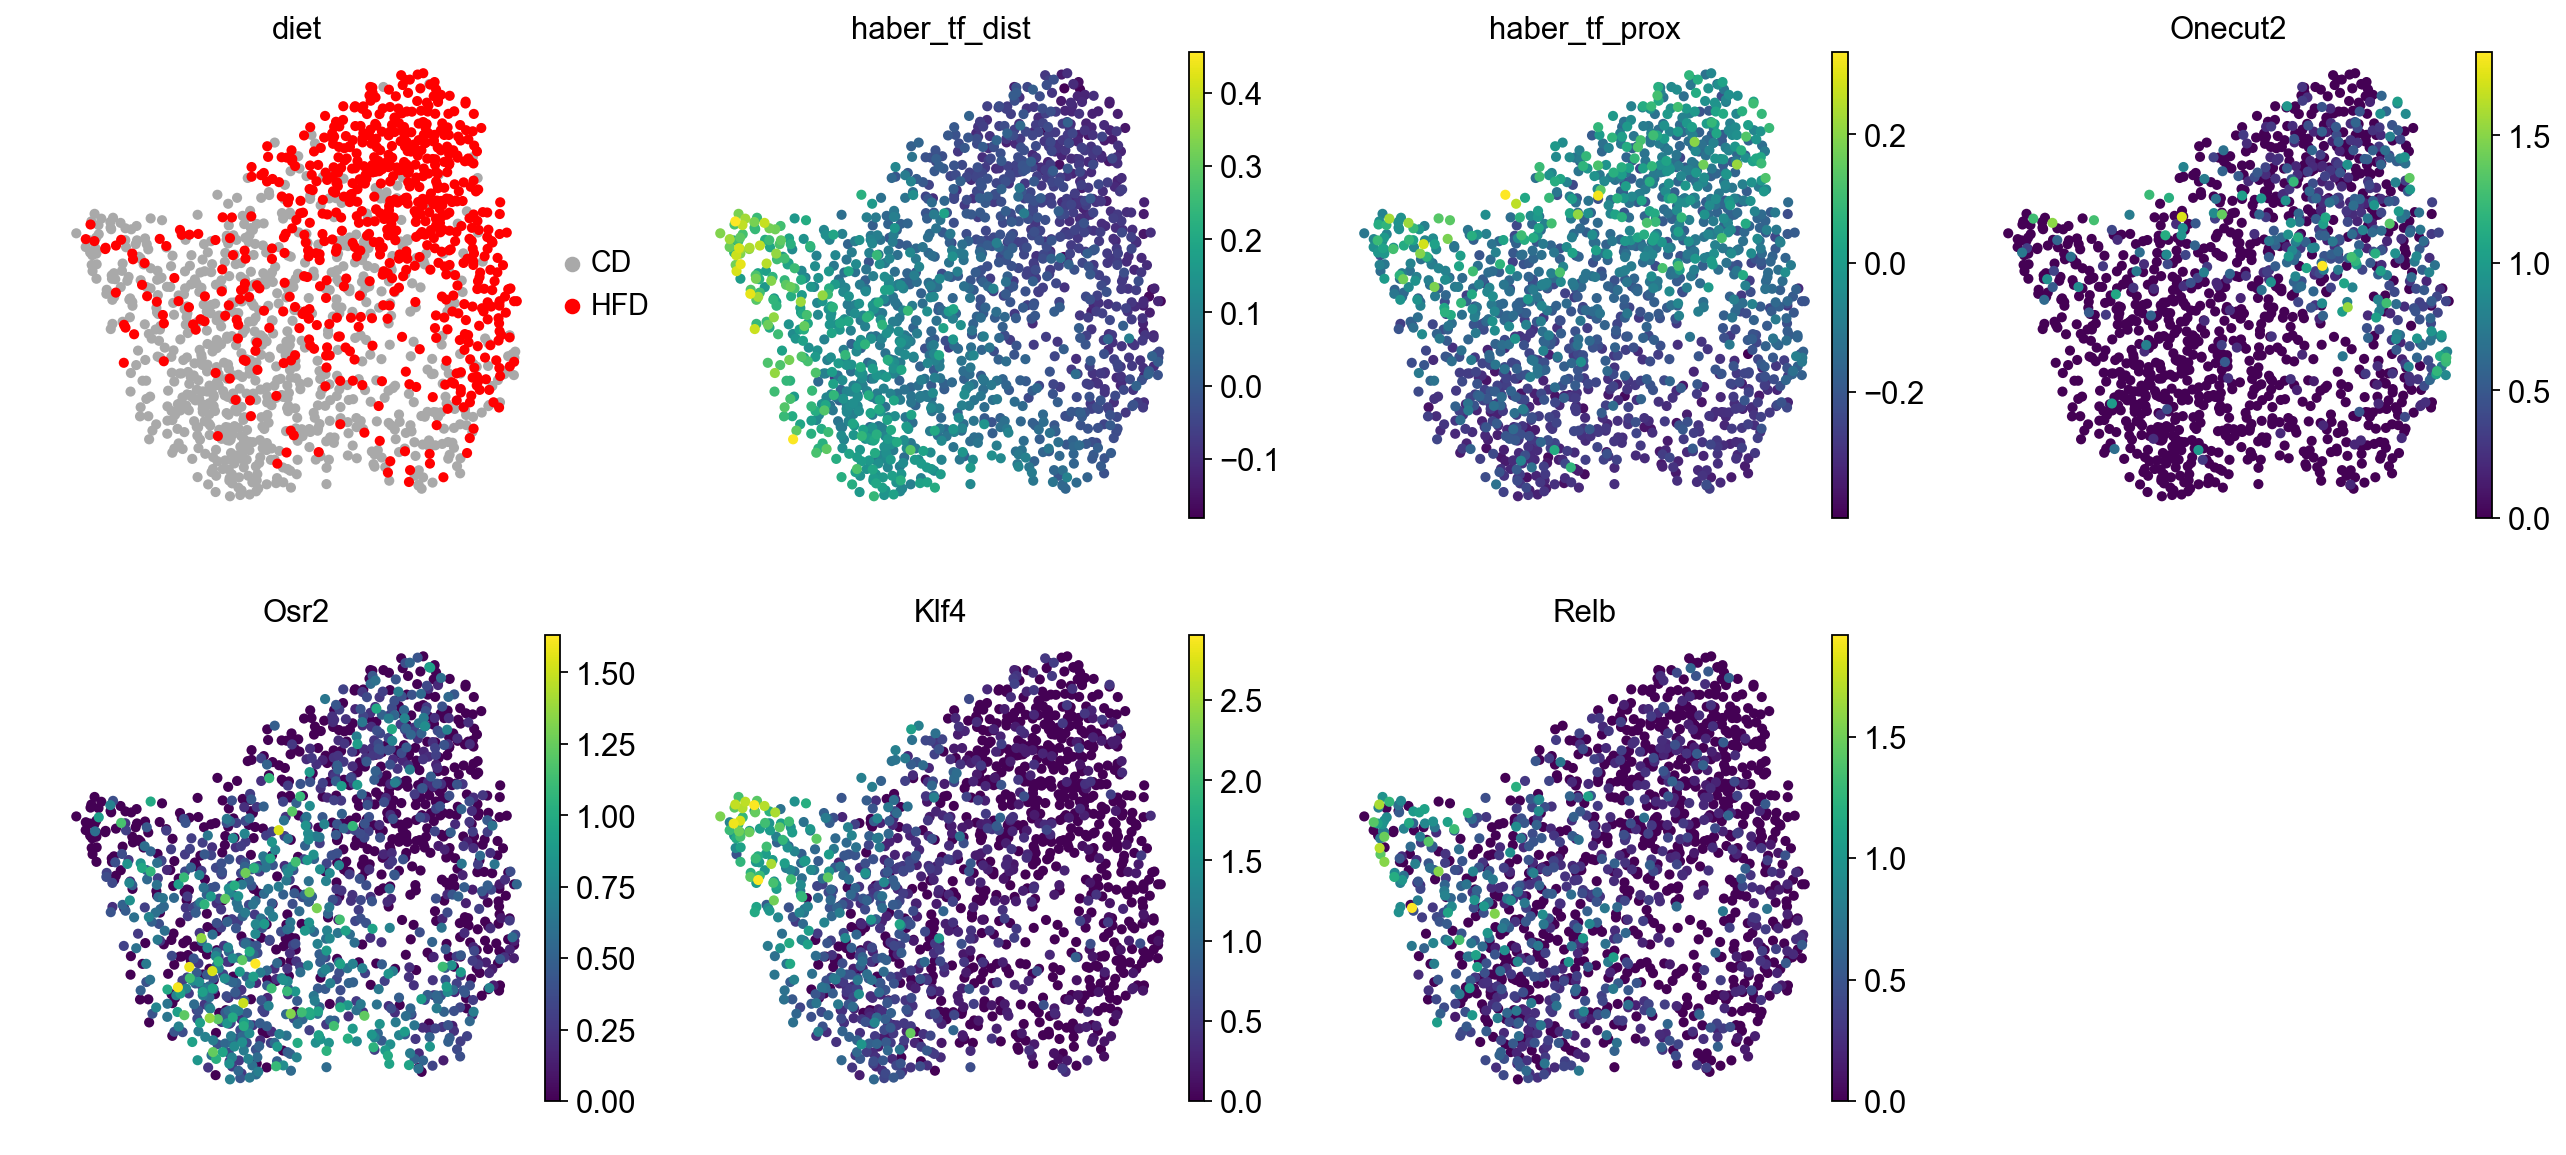

In [22]:
sc.pl.umap(adata_ent_reg, color=['diet', 'haber_tf_dist', 'haber_tf_prox', 'Onecut2', 'Osr2', 'Klf4', 'Relb'])

clustering

In [23]:
sc.tl.louvain(adata_ent_reg, resolution=1)
sc.tl.louvain(adata_ent_reg, restrict_to=('louvain', ['2']), key_added='louvain_r', resolution=0.5)
sc.tl.louvain(adata_ent_reg, restrict_to=('louvain_r', ['4']), key_added='louvain_r', resolution=0.7)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)


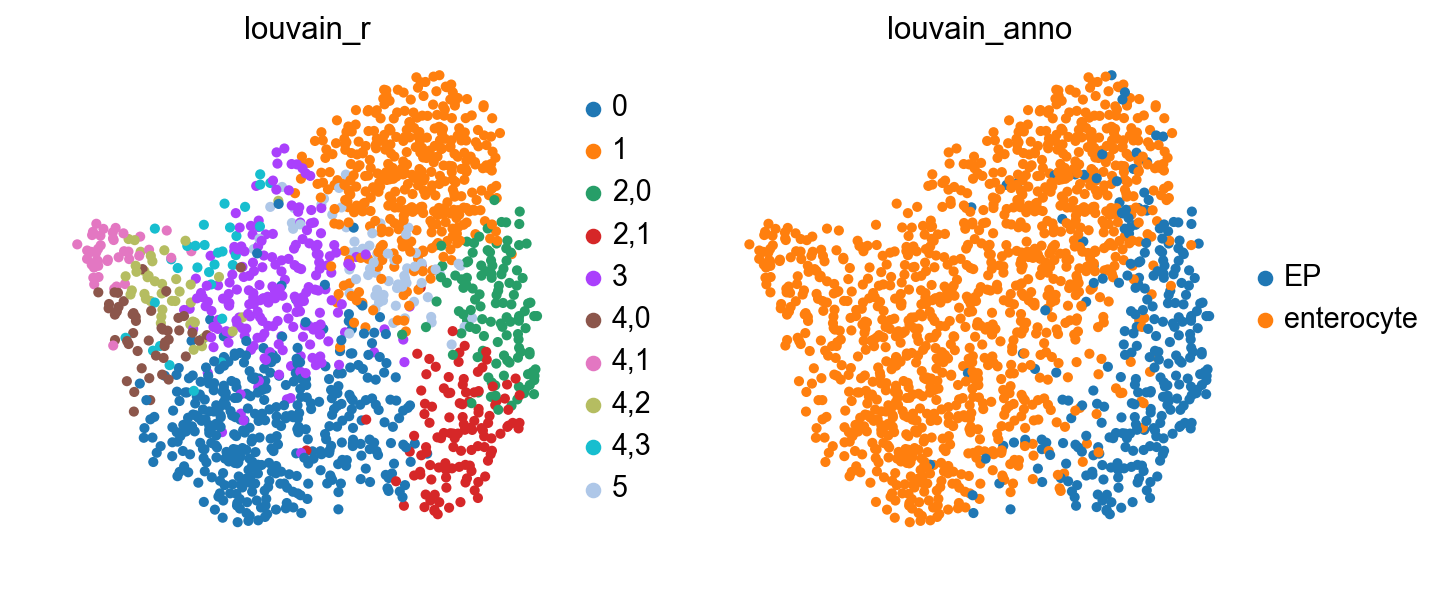

In [24]:
sc.pl.umap(adata_ent_reg, color=['louvain_r', 'louvain_anno'])

regional cluster annotation

/Users/stritschler/code/miniconda3/envs/scanpy_14/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/stritschler/code/miniconda3/envs/scanpy_14/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/stritschler/code/miniconda3/envs/scanpy_14/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit

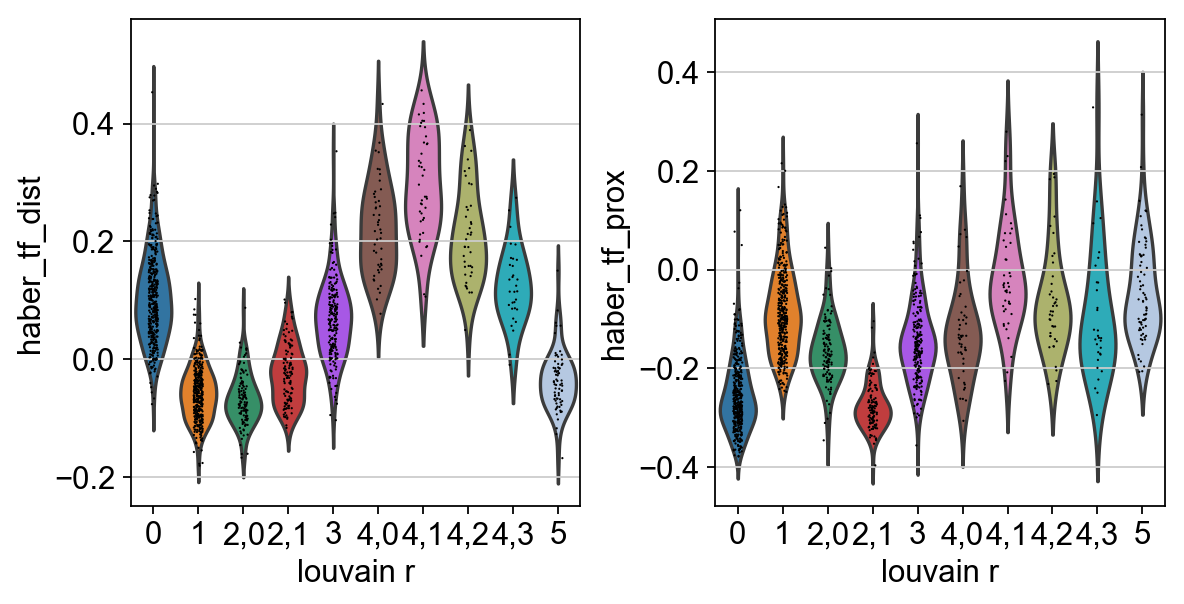

In [25]:
sc.pl.violin(adata_ent_reg, groupby='louvain_r', keys=['haber_tf_dist', 'haber_tf_prox'])

In [26]:
# annotation
map_names = {}
for c in adata_ent_reg.obs['louvain_r'].cat.categories:
    if c in ['2,0', '1', '3', '4,2', '5', '4,3']:
        map_names[c] = 'proximal'
    elif c in ['2,1', '0', '4,1', '4,0']:
        map_names[c] = 'distal'

adata_ent_reg.obs['regionality']=adata_ent_reg.obs['louvain_r']
adata_ent_reg.obs['regionality']=adata_ent_reg.obs['regionality'].map(map_names).astype('category')

In [27]:
adata_ent_reg.obs['regionality'].cat.reorder_categories(['proximal', 'distal'], inplace=True)

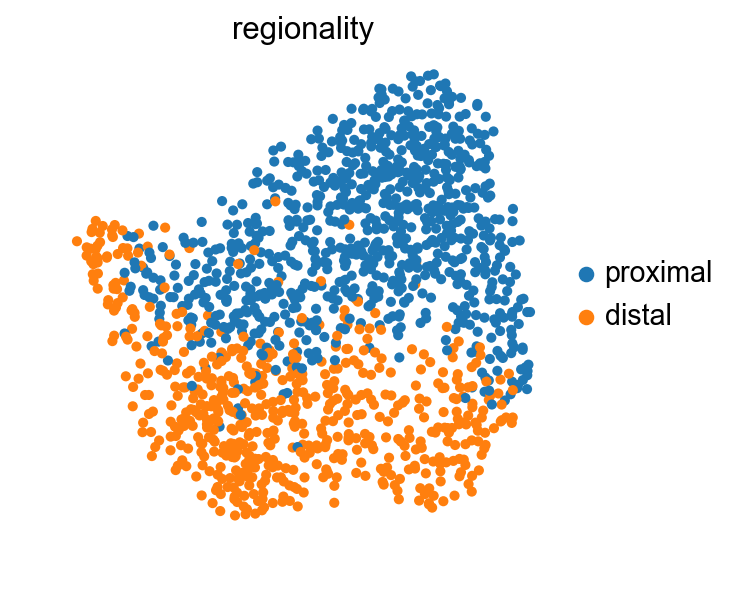

In [29]:
sc.settings.figdir = '/Users/stritschler/Documents/ICB/2020_HFD_villus/figures/slide_1/'
sc.pl.umap(adata_ent_reg, color='regionality', save='_entero_regionality.pdf')

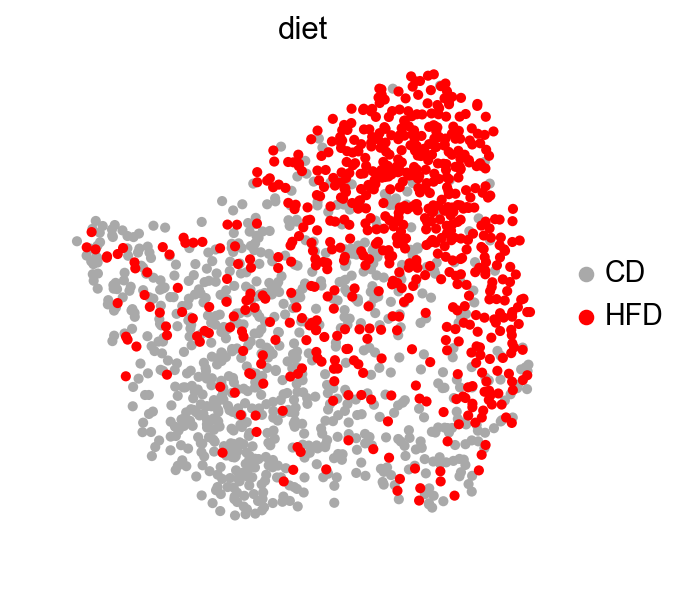

In [30]:
sc.settings.figdir = '/Users/stritschler/Documents/ICB/2020_HFD_villus/figures/'
sc.pl.umap(adata_ent_reg, color='diet', save='_entero_diet.pdf')

/Users/stritschler/code/miniconda3/envs/scanpy_14/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  if sys.path[0] == '':


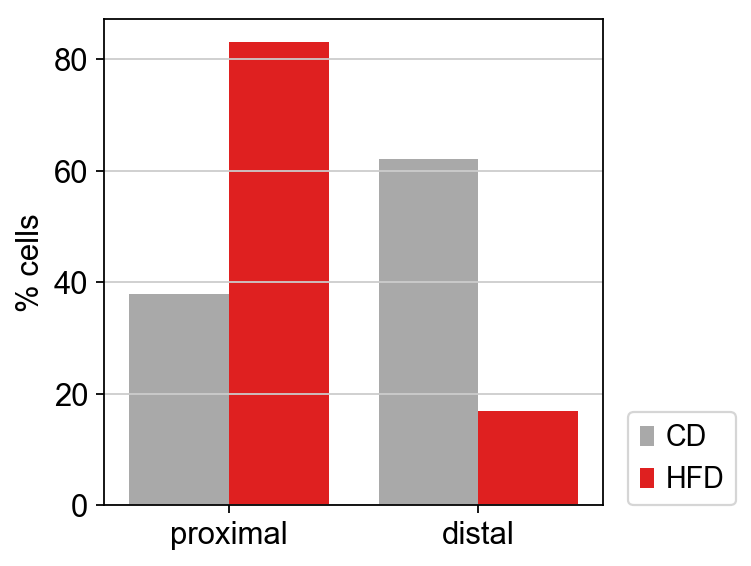

In [31]:
population_barplot(adata_ent_reg, 'regionality', 'diet', save=True, 
                   filename='/Users/stritschler/Documents/ICB/2020_HFD_villus/figures/slide_1/barplot_entero_regionality.pdf')

### Functional chracetrization and differential expression btw. gut regions

In [32]:
adata_ent.obs['regionality'] = adata_ent_reg.obs['regionality']

In [33]:
adata_ent.obs['regionality_diet'] = [a + '_' + b for a,b in zip(adata_ent.obs.regionality, adata_ent.obs.diet)]

we exclude highly exrpressed immune cell markers (ambient genes expression)

In [87]:
immune_genes = ['Jchain', 'Igkc','Hbb-bt', 'Hbb-bs', 'Mcpt1', 'Mcpt2', 'Hba-a1', 'Hba-a2', 'Igha', 'Ighg2b', 'Ighg1', 'Ighg3', 'Ighm', 'Iglc1', 'Igkv12-44']

... storing 'diet' as categorical
... storing 'louvain' as categorical
... storing 'louvain_r' as categorical
... storing 'louvain_anno' as categorical


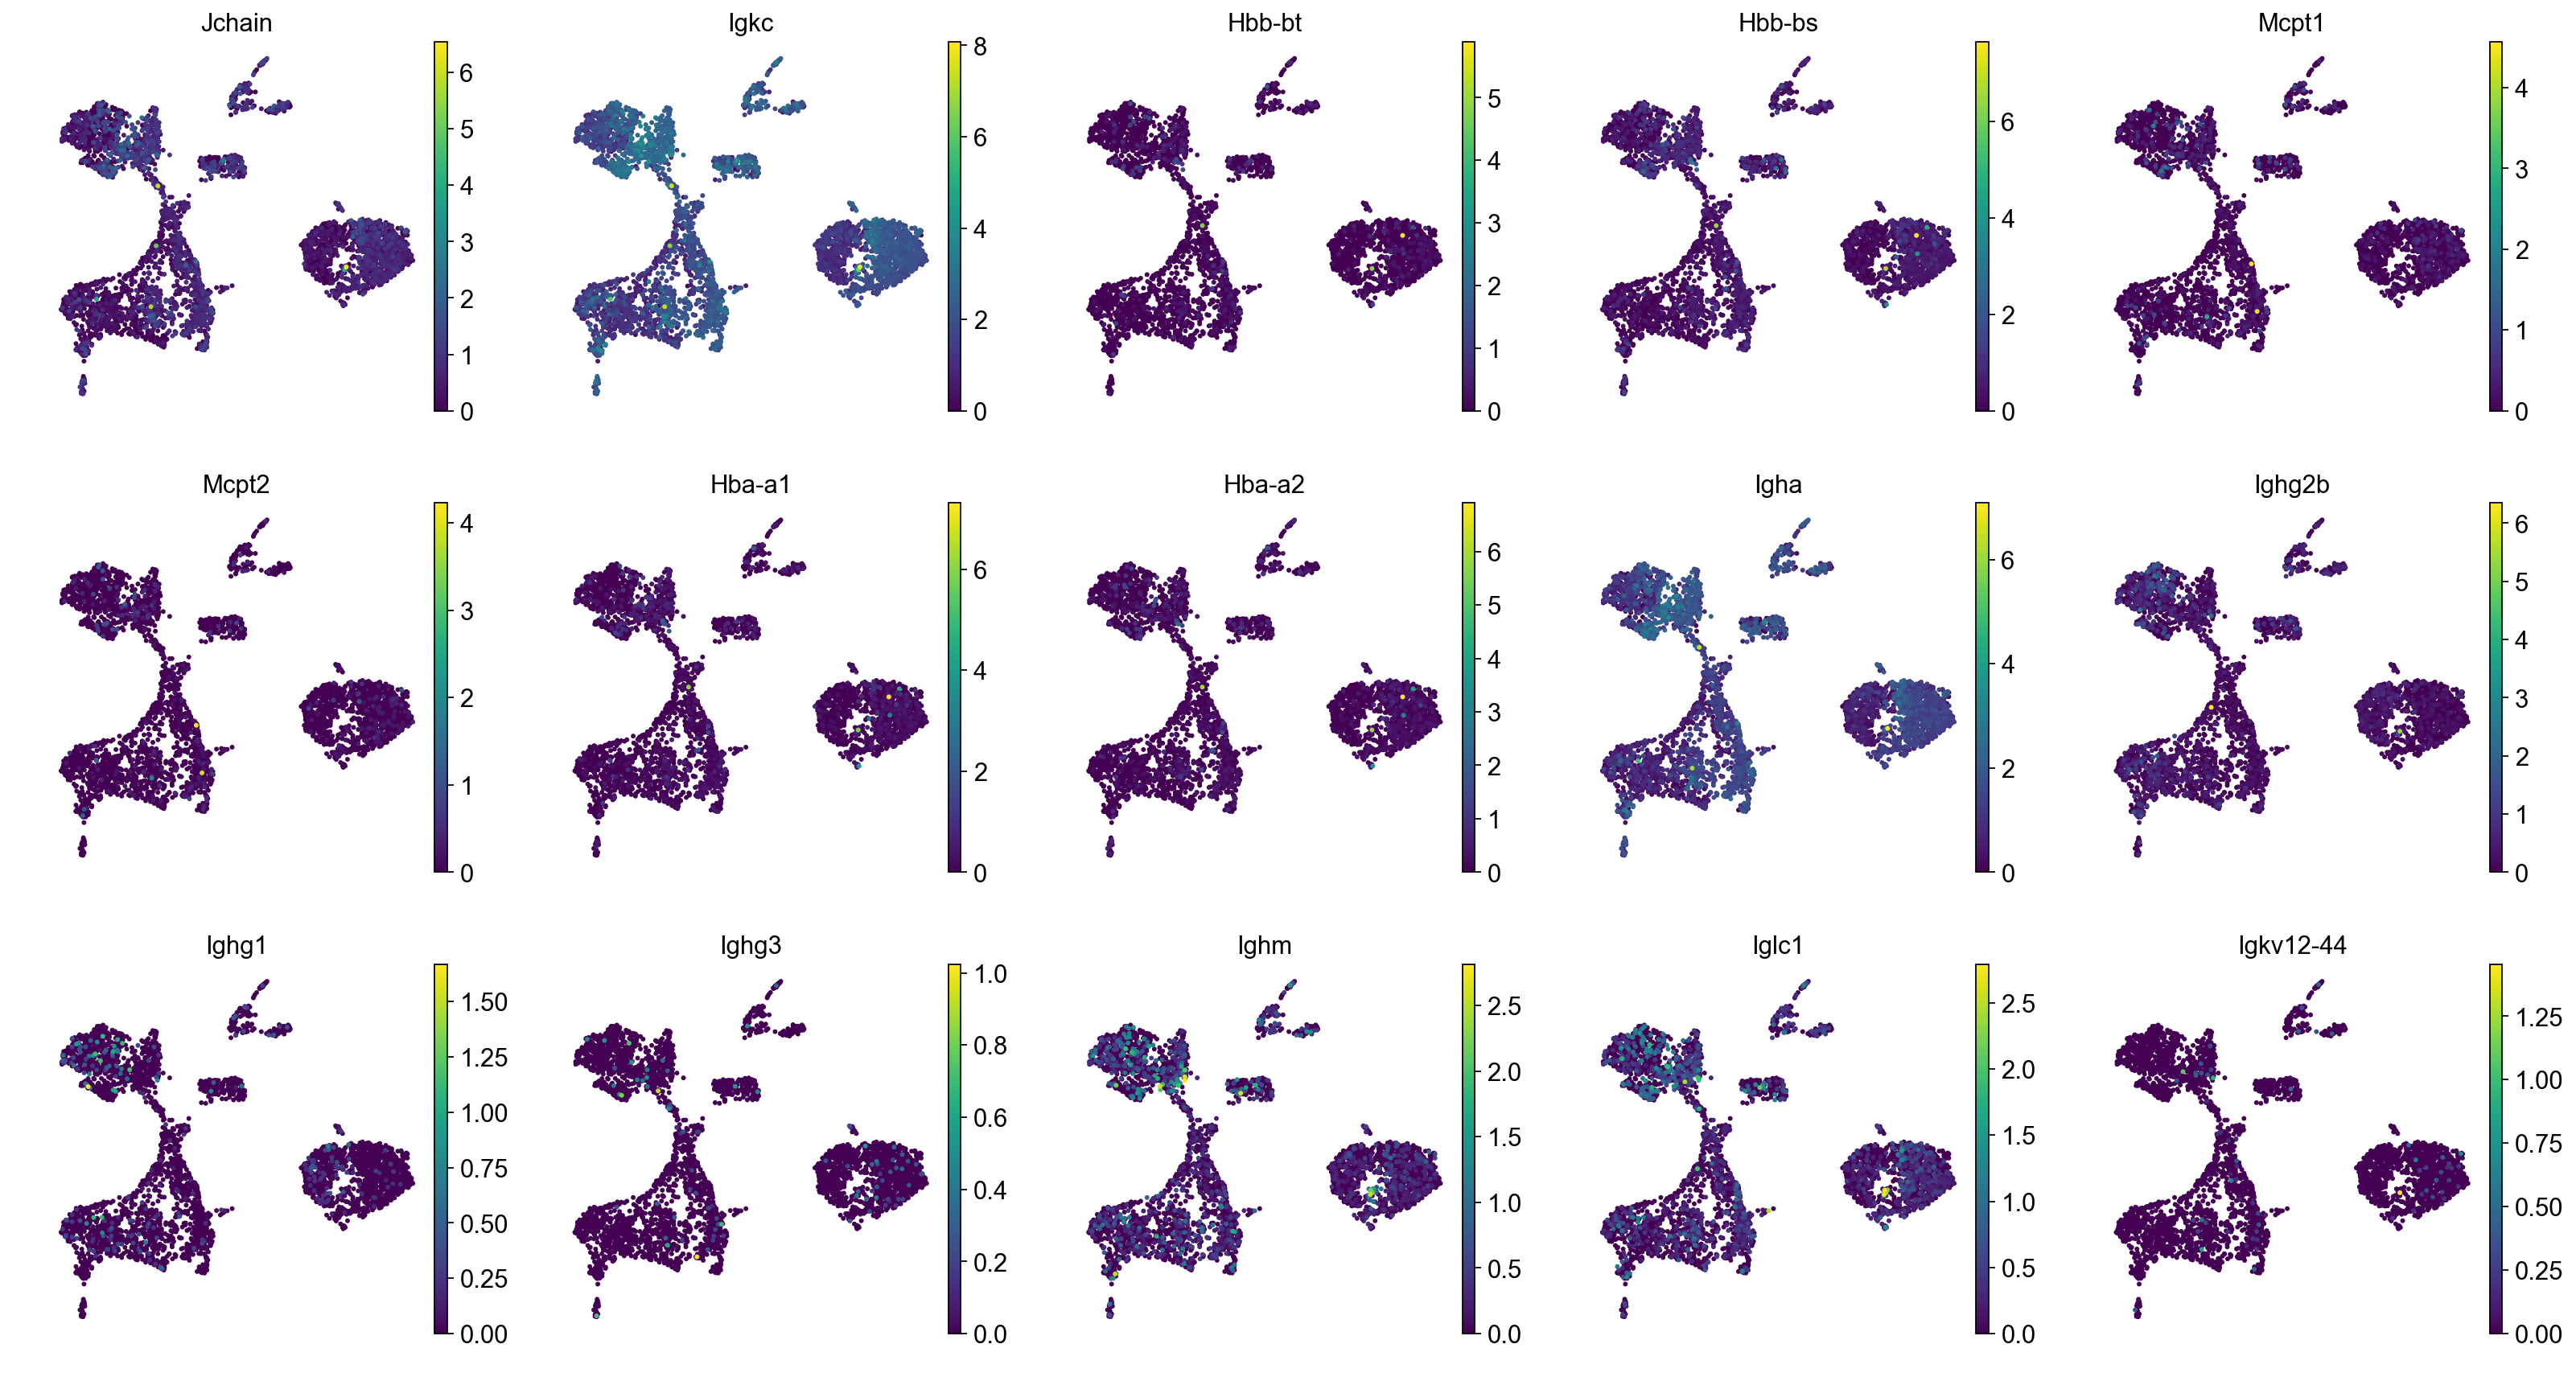

In [88]:
sc.pl.umap(adata, color=immune_genes, ncols=5)

In [89]:
adata_sub = adata_ent.copy()
sc.pp.filter_genes(adata_sub, min_cells=20)
adata_sub = adata_sub[:, np.invert(adata_sub.var_names.isin(immune_genes))].copy()

filtered out 4975 genes that are detectedin less than 20 cells


In [90]:
adata_sub = adata_sub[adata_sub.obs.louvain_anno.isin(['enterocyte'])].copy()

#### differential expression of gut regional markers

In [79]:
adata_dist = adata_sub[adata_sub.obs.regionality.isin(['distal'])].copy()
adata_prox = adata_sub[adata_sub.obs.regionality.isin(['proximal'])].copy()

In [80]:
sc.tl.rank_genes_groups(adata_dist, groupby='diet', method='t-test', n_genes=adata_dist.n_vars)
sc.tl.rank_genes_groups(adata_prox, groupby='diet', method='t-test', n_genes=adata_dist.n_vars)

ranking genes
    finished (0:00:00)
ranking genes
    finished (0:00:00)


In [82]:
df_dist = sc.get.rank_genes_groups_df(adata_dist, group='HFD').set_index('names')
df_prox = sc.get.rank_genes_groups_df(adata_prox, group='HFD').set_index('names')

In [92]:
df = pd.DataFrame(index=[k for k in genes_crypt_prox + genes_crypt_dist if k in adata_dist.var_names], columns=['logF_proximal', 'pval_proximal', 'logF_distal', 'pval_distal'])

In [93]:
df_crypt_prox = df_dist.loc[[k for k in genes_crypt_prox + genes_crypt_dist if k in df_dist.index]]#.sort_values(by='logfoldchanges', ascending=False)
df_crypt_dist = df_prox.loc[[k for k in genes_crypt_prox + genes_crypt_dist if k in df_prox.index ]]#.sort_values(by='logfoldchanges', ascending=False)
df.loc[df_crypt_dist.index,['logF_distal', 'pval_distal']] = df_crypt_dist[['logfoldchanges', 'pvals_adj']].values
df.loc[df_crypt_prox.index,['logF_proximal', 'pval_proximal']] = df_crypt_prox[['logfoldchanges', 'pvals_adj']].values

In [94]:
genes = [k for k in genes_crypt_prox + genes_crypt_dist if k in adata_dist.var_names]

In [95]:
df_p = pd.DataFrame(index=genes, columns=['sig_distal', 'sig_proximal'])
df_p['sig_distal'] = ['*' if a <0.01 else ' ' for a in df['pval_distal'].loc[genes].values]
df_p['sig_proximal'] = ['*' if a <0.01 else ' ' for a in df['pval_proximal'].loc[genes].values]

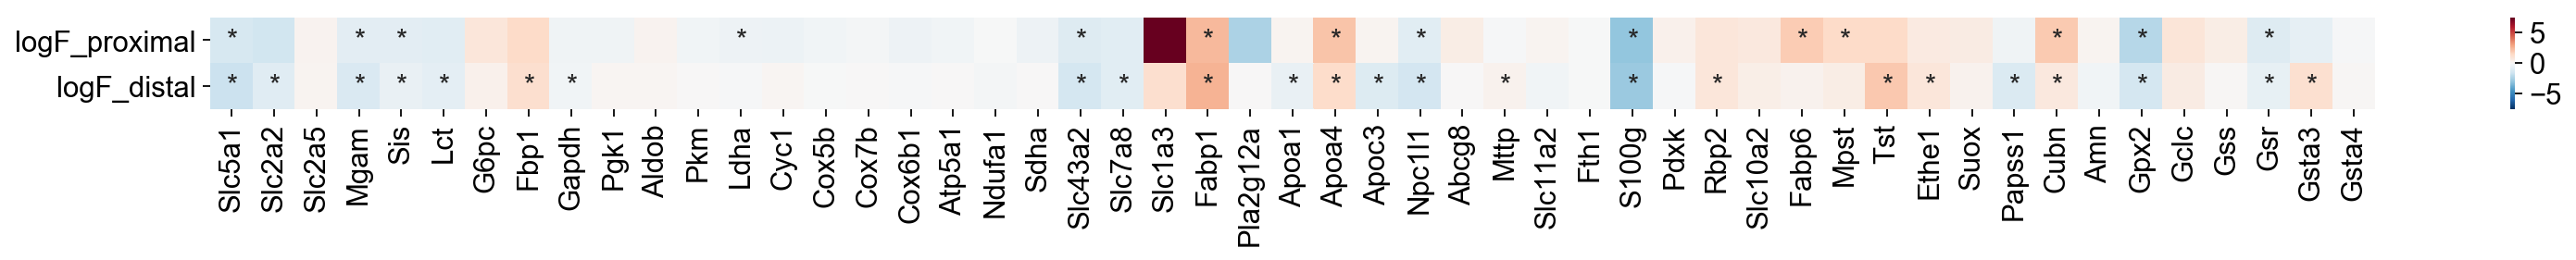

In [97]:
fig,ax=pl.subplots(figsize=(20,2))
sns.heatmap(df.loc[genes, ['logF_proximal', 'logF_distal']].fillna('0').T, center=0, cmap='RdBu_r', vmin=-7.5, vmax=7.5, 
            annot=df_p.loc[:,['sig_proximal', 'sig_distal']].T, fmt='')
pl.tight_layout()
pl.savefig('/Users/stritschler/Documents/ICB/2020_HFD_villus/figures/slide_15/heatmap_crypt_marker.pdf', dpi=300)


#### differential expression HFD vs. CD

In [91]:
sc.tl.rank_genes_groups(adata_sub, groupby='diet', method='t-test', n_genes=adata_sub.n_vars)

ranking genes
    finished (0:00:00)


In [92]:
df_all = sc.get.rank_genes_groups_df(adata_sub, group='HFD').set_index('names')

In [93]:
df_all = df_all[df_all.pvals_adj<0.05]
df_all = df_all[abs(df_all.logfoldchanges)>0.1]

In [128]:
import gseapy as gp
df_up = gp.enrichr(gene_list=df_all[df_all.logfoldchanges>0.5].index.tolist(),
               description='',
               gene_sets='KEGG_2016',#
               cutoff=0.05
              ).res2d.set_index('Term')
df_down = gp.enrichr(gene_list=df_all[df_all.logfoldchanges<-0.5].index.tolist(),
               description='',
               gene_sets='KEGG_2016',
               cutoff=0.05
              ).res2d.set_index('Term')

In [129]:
df_up.reset_index(inplace=True)
df_down.reset_index(inplace=True)

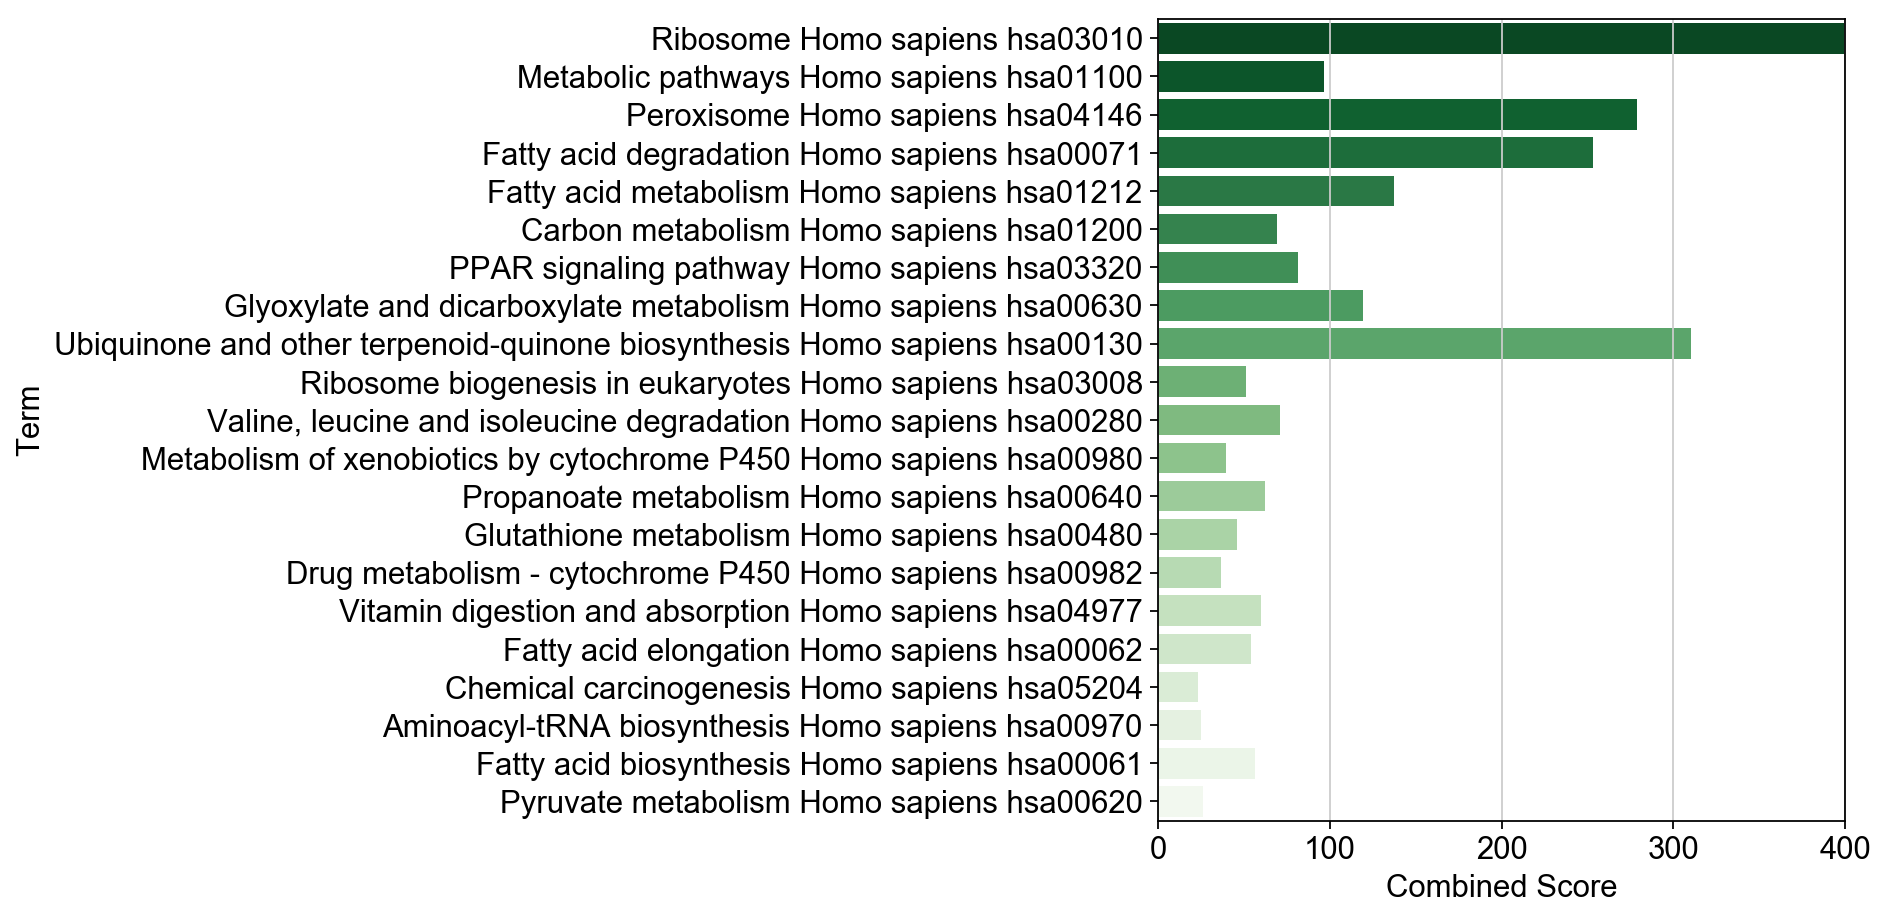

In [137]:
# removed ribosome term
fig,ax=pl.subplots(figsize=(12,6))
sns.barplot(data=df_up.loc[0:20], y='Term', x='Combined Score', orient='horizontal', palette='Greens_r', ax=ax)
ax.set_xlim([0,400])
pl.tight_layout()
pl.savefig('/Users/stritschler/Documents/ICB/2020_HFD_villus/figures/slide_11_12/pathways_HFD.pdf', dpi=300)

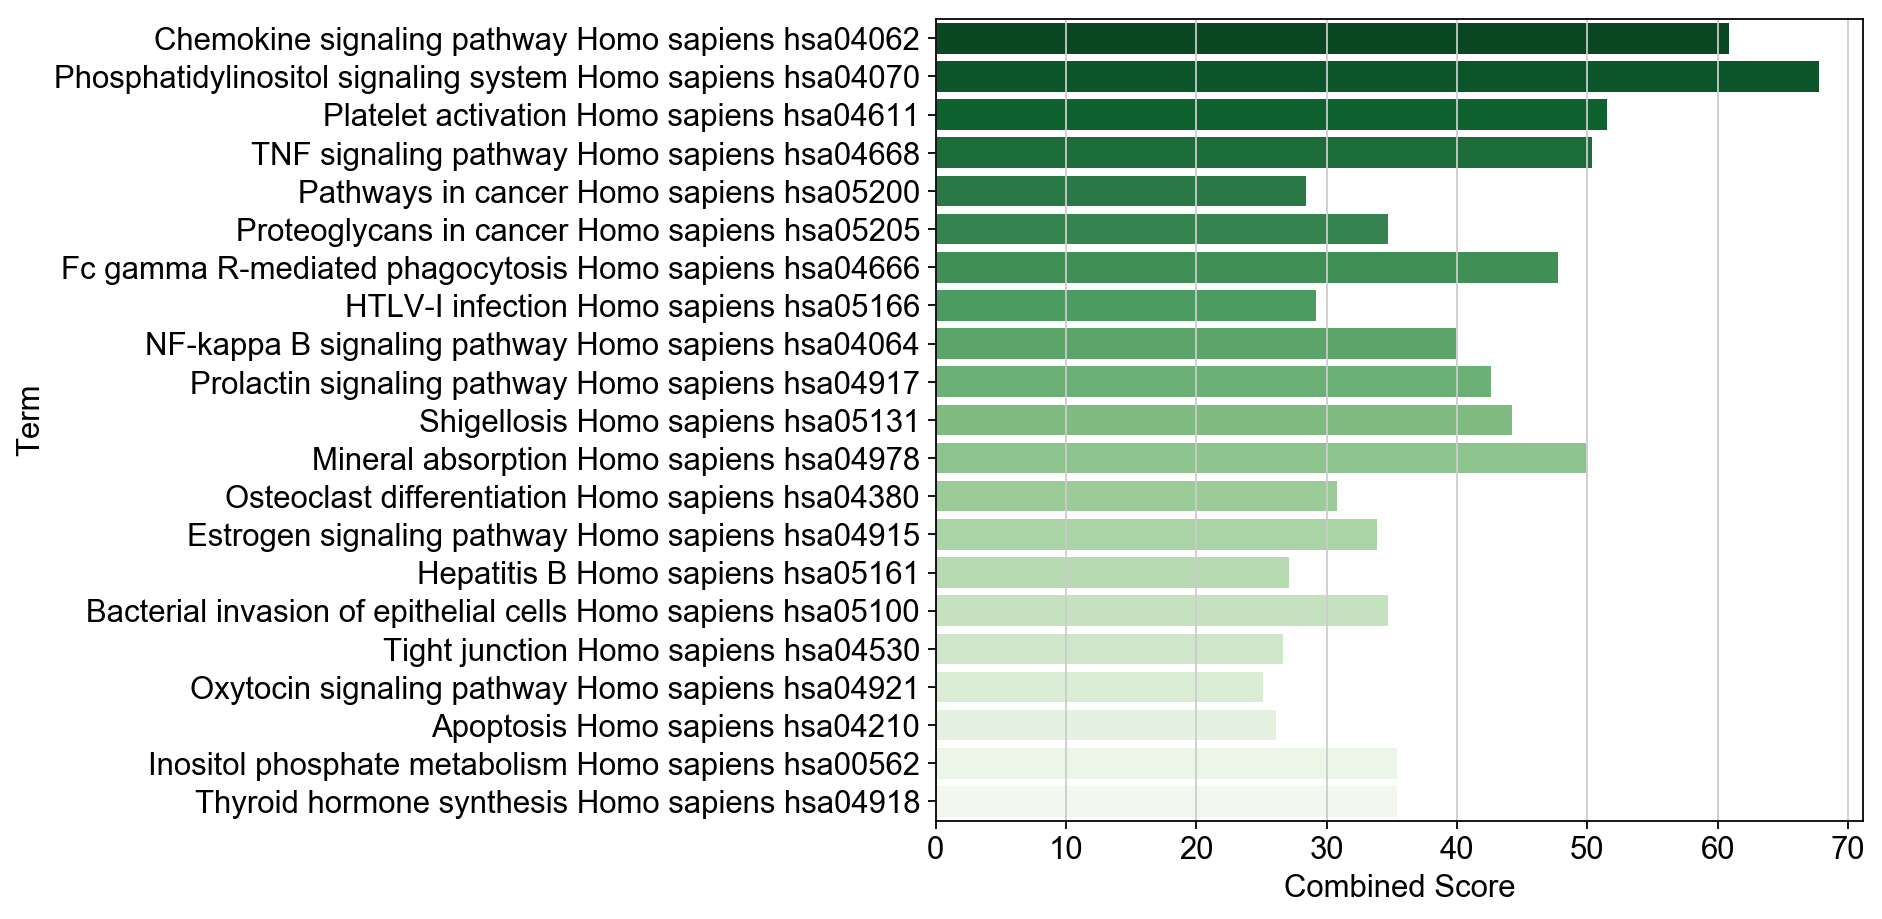

In [138]:
fig,ax=pl.subplots(figsize=(12,6))
sns.barplot(data=df_down.loc[0:20], y='Term', x='Combined Score', orient='horizontal', palette='Greens_r', ax=ax)
pl.tight_layout()
pl.savefig('/Users/stritschler/Documents/ICB/2020_HFD_villus/figures/slide_11_12/pathways_CD.pdf', dpi=300)

#### expression of functional markers HFD vs. CD

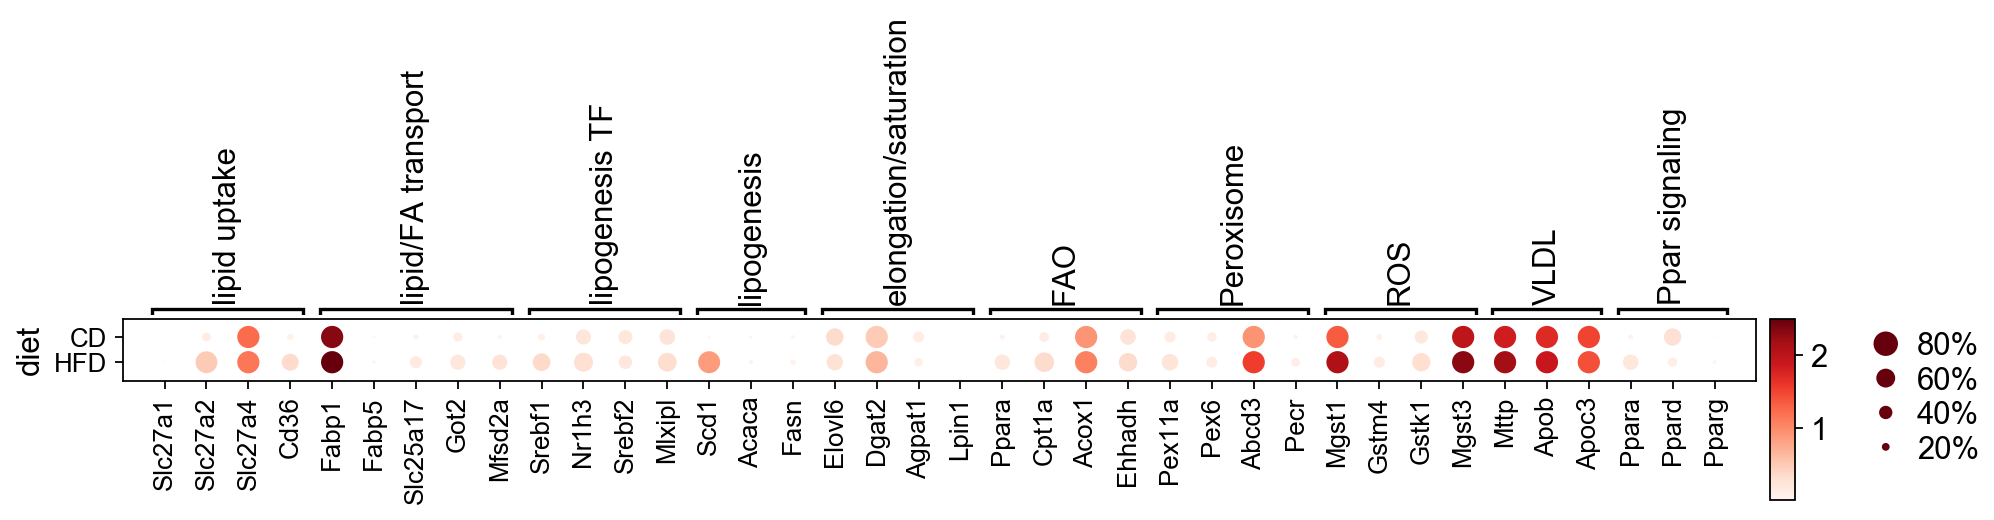

GridSpec(2, 5, height_ratios=[0.5, 10], width_ratios=[13.299999999999999, 0, 0.2, 0.5, 0.25])

In [148]:
sc.settings.figdir = '/Users/stritschler/Documents/ICB/2020_HFD_villus/figures/slide_10/'

genes = ['Slc27a1', 'Slc27a2', 'Slc27a4', 'Cd36', #lipid uptake
         'Fabp1', 'Fabp5', 'Slc25a17', 'Got2', 'Mfsd2a', #lipid/FA transport
         'Srebf1', 'Nr1h3', 'Srebf2', 'Mlxipl', #lipogenesis TF
         'Scd1', 'Acaca', 'Fasn', #lipogenesis
         'Elovl6', 'Dgat2',  'Agpat1', 'Lpin1', #elongation/saturation
         'Ppara', 'Cpt1a', 'Acox1', 'Ehhadh', #FAO
         'Pex11a', 'Pex6', 'Abcd3', 'Pecr', #Peroxisome
         'Mgst1', 'Gstm4', 'Gstk1', 'Mgst3', #ROS
         'Mttp', 'Apob', 'Apoc3', #VLDL
         'Ppara', 'Ppard', 'Pparg' #Ppar signaling
        ]


sc.pl.dotplot(adata_sub, var_names=genes,
              var_group_labels=['lipid uptake', 'lipid/FA transport', 'lipogenesis TF', 'lipogenesis', 'elongation/saturation', 'FAO', 
                                'Peroxisome', 'ROS', 'VLDL', 'Ppar signaling'],
              var_group_positions=[(0,3), (4,8), (9,12), (13,15), (16,19), (20,23),(24,27), (28,31), (32,34), (35,37)],
              groupby='diet', vmax=2.5, dot_max=0.8, save='_lipid_metabo.pdf')

### Enterocyte zonation

#### Zonation cell scoring

zonation genes from Moor et al., 2018

In [48]:
df_zon = pd.read_excel('./data/zonation_genes.xlsx')

In [49]:
for col in df_zon.columns:
    sc.tl.score_genes(adata_ent, gene_list=[k for k in list(df_zon[col].values) if k in adata_ent.var_names], score_name=col)

computing score 'Cluster 1'
    finished (0:00:00)
computing score 'Cluster 2'
    finished (0:00:00)
computing score 'Cluster 3'
    finished (0:00:00)
computing score 'Cluster 4'
    finished (0:00:00)
computing score 'Cluster 5'
    finished (0:00:00)


#### DPT along crypt-villus zonation axis

subset to zonation markers

In [50]:
zon_genes = []
for col in df_zon.columns:
    zon_genes = zon_genes + [k for k in list(df_zon[col].values) if k in adata_ent.var_names]

In [51]:
adata_ent_zon = adata_ent[:,zon_genes].copy()

In [115]:
len(zon_genes)

2056

comput kNN and manifold in zonation marker space

In [52]:
sc.pp.highly_variable_genes(adata_ent_zon, n_top_genes=1000)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [53]:
sc.pp.pca(adata_ent_zon, use_highly_variable=True, n_comps=30)

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 30
computing PCA on highly variable genes
    finished (0:00:00)


use bbknn to overlay CD and HFD samples

In [54]:
import scanpy.external as sce
sce.pp.bbknn(adata_ent_zon, batch_key='diet')
sc.tl.umap(adata_ent_zon)

computing batch balanced neighbors
	finished (0:00:01)
computing UMAP
    finished (0:00:01)


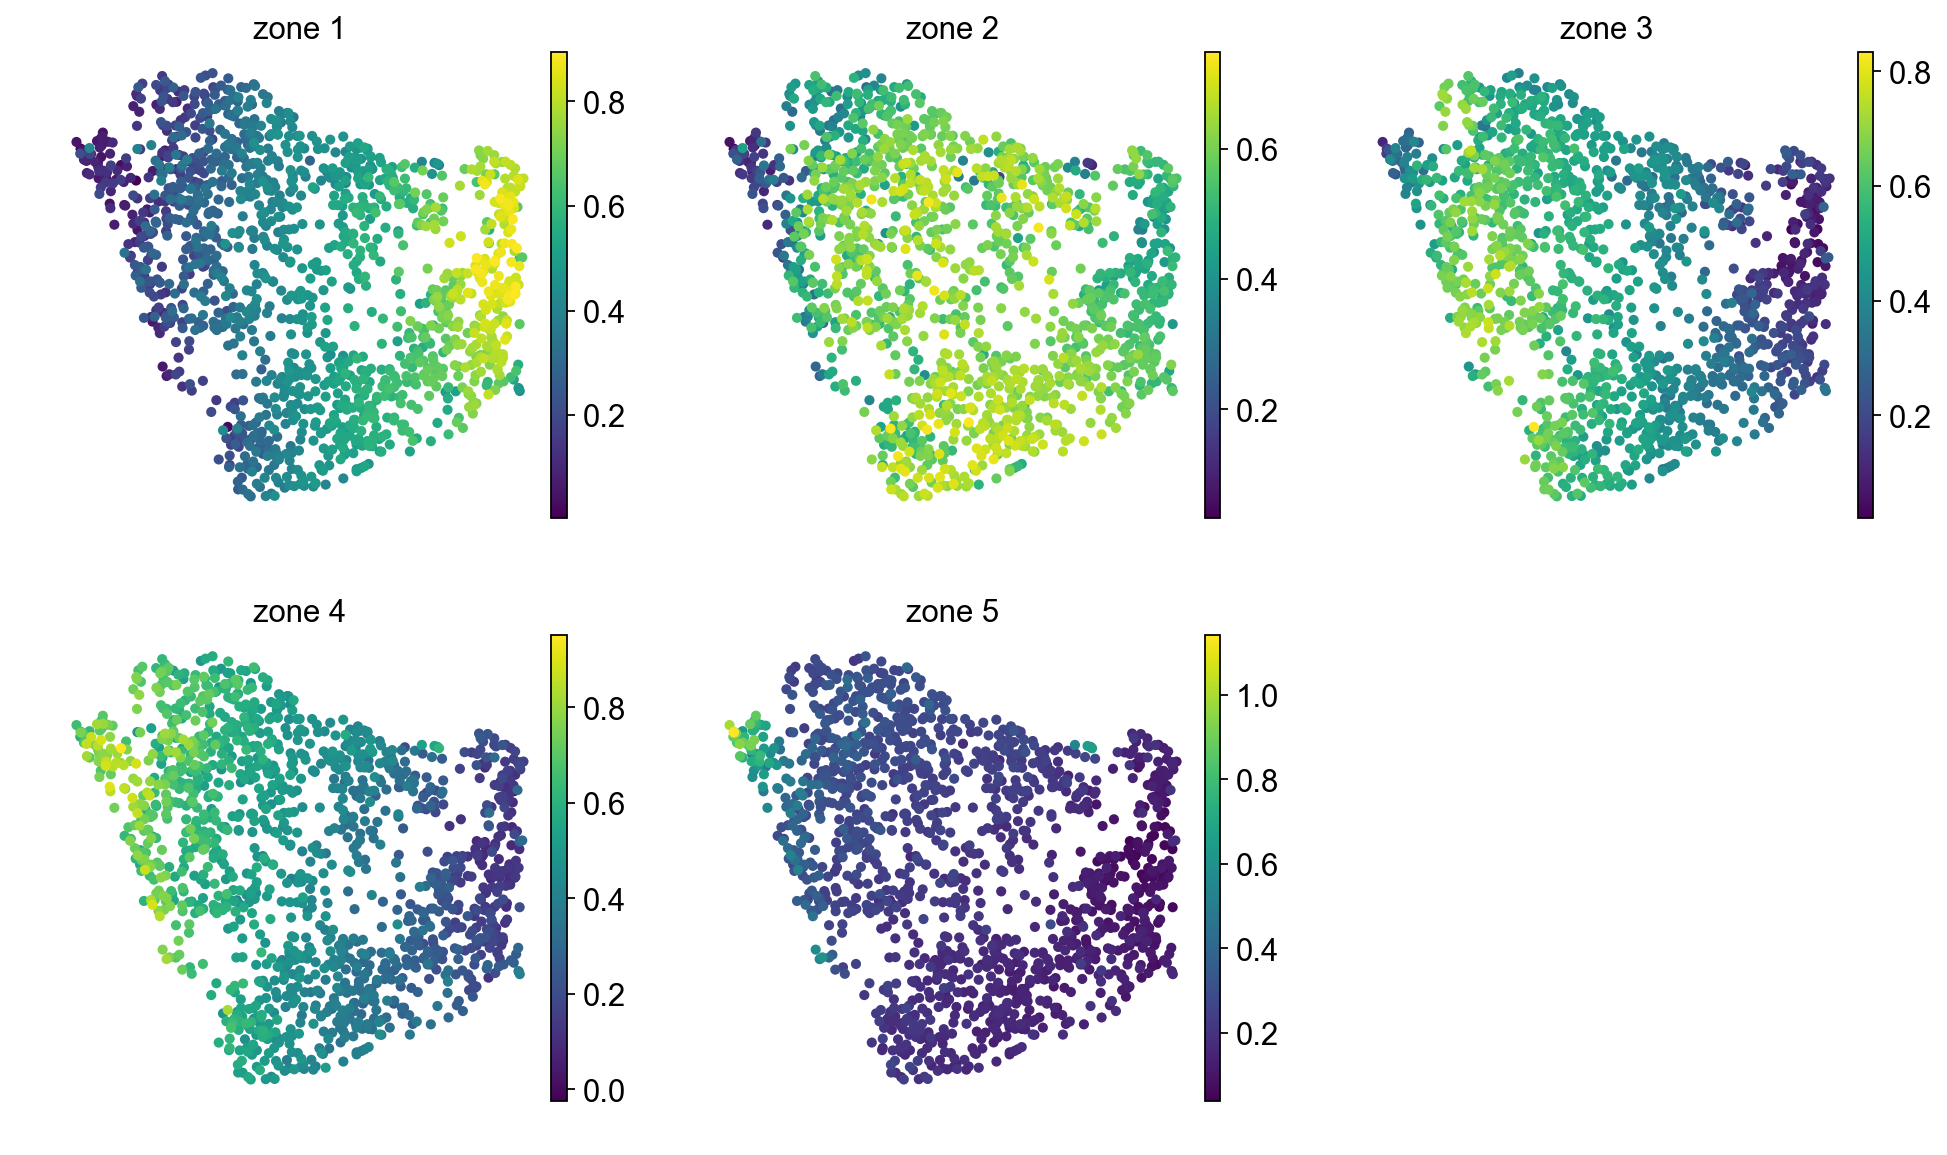

In [55]:
sc.set_figure_params(vector_friendly=True,color_map='viridis',dpi_save=300,transparent=True, frameon=False)
sc.pl.umap(adata_ent_zon, color=df_zon.columns, ncols=3, title=['zone 1', 'zone 2', 'zone 3', 'zone 4', 'zone 5'])

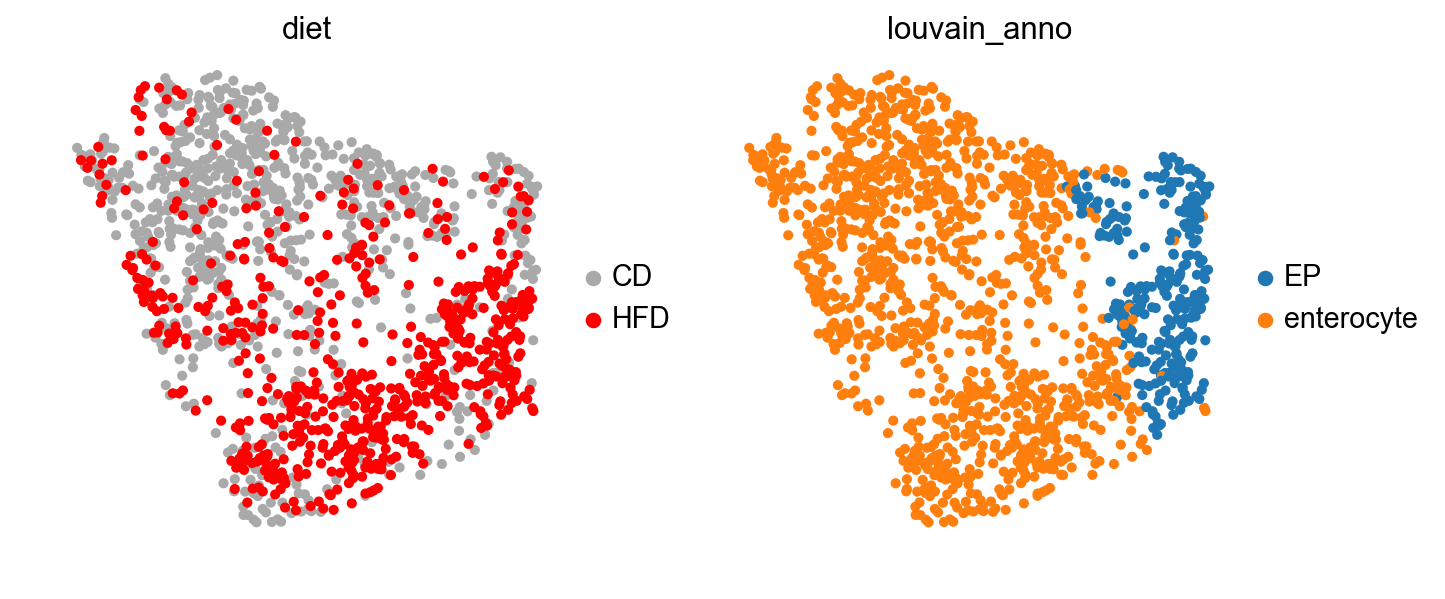

In [56]:
sc.pl.umap(adata_ent_zon, color=['diet', 'louvain_anno'], ncols=5)

compute DPT-based ordering from crypt to villus

In [57]:
adata_ent_zon.uns['iroot'] = np.flatnonzero(adata_ent_zon.obs['louvain_anno']  == 'EP')[0] #random root cell in EP cluster
sc.tl.dpt(adata_ent_zon)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [0.999998   0.99361485 0.9849608  0.97553396 0.9680492  0.9671756
     0.957666   0.95310706 0.9448214  0.94276565 0.9379084  0.9357919
     0.9307196  0.92926776 0.92643064]
    finished (0:00:00)
computing Diffusion Pseudotime using n_dcs=10
    finished (0:00:00)


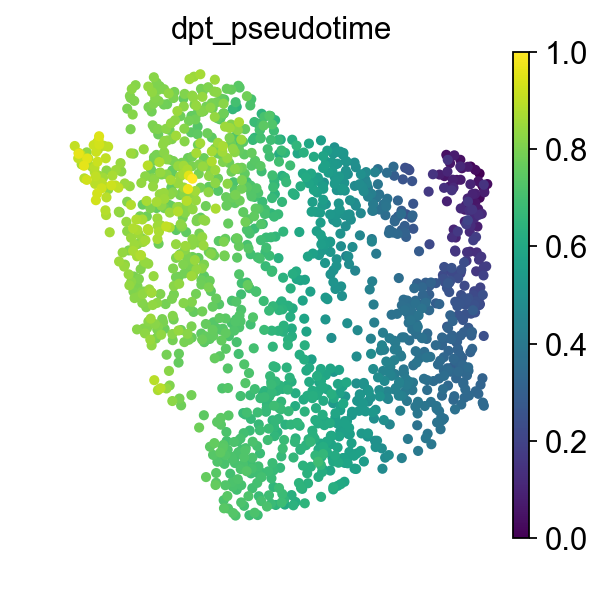

In [58]:
sc.pl.umap(adata_ent_zon, color=['dpt_pseudotime'], ncols=5)

#### Cell binning into 5 zones along DPT

In [64]:
df = adata_ent_zon.obs.copy()
df.sort_values(by='dpt_pseudotime', ascending=True, inplace=True)
df['cell_order']=range(0, df.shape[0])

In [65]:
cols = sns.color_palette("viridis_r", 6)

In [66]:
adata_ent_zon.uns['diet_colors'] = ['darkgrey', 'red']

define cell bins based on crossing points of zonation scores along dpt axis

In [67]:
# fit regression lines

xmin, xmax = 0, adata_ent_zon.n_obs
grid = np.linspace(xmin, xmax, 100)
order = 4

x, y = df['cell_order'], df[df_zon.columns[0]]
fit_1 = np.polyval(np.polyfit(x, y, order), grid)

x, y = df['cell_order'], df[df_zon.columns[1]]
fit_2 = np.polyval(np.polyfit(x, y, order), grid)

x, y = df['cell_order'], df[df_zon.columns[2]]
fit_3 = np.polyval(np.polyfit(x, y, order), grid)

x, y = df['cell_order'], df[df_zon.columns[3]]
fit_4 = np.polyval(np.polyfit(x, y, order), grid)

x, y = df['cell_order'], df[df_zon.columns[4]]
fit_5 = np.polyval(np.polyfit(x, y, order), grid)

In [68]:
# find crossing points

for i,(a,b) in enumerate(zip(fit_1, fit_2)):
    if b>a:
        cut_1 = grid[i-1]
        break
        
for i,(a,b) in enumerate(zip(fit_2, fit_3)):
    if b>a:
        cut_2 = grid[i-1]
        break
        
for i,(a,b) in enumerate(zip(fit_3, fit_4)):
    if a>0.3:
        if b>a:
            cut_3 = grid[i-1]
            break
        
for i,(a,b) in enumerate(zip(fit_3, fit_5)):
    if a>0.3:
        if b>a:
            cut_4 = grid[i-1]
            break

plotting

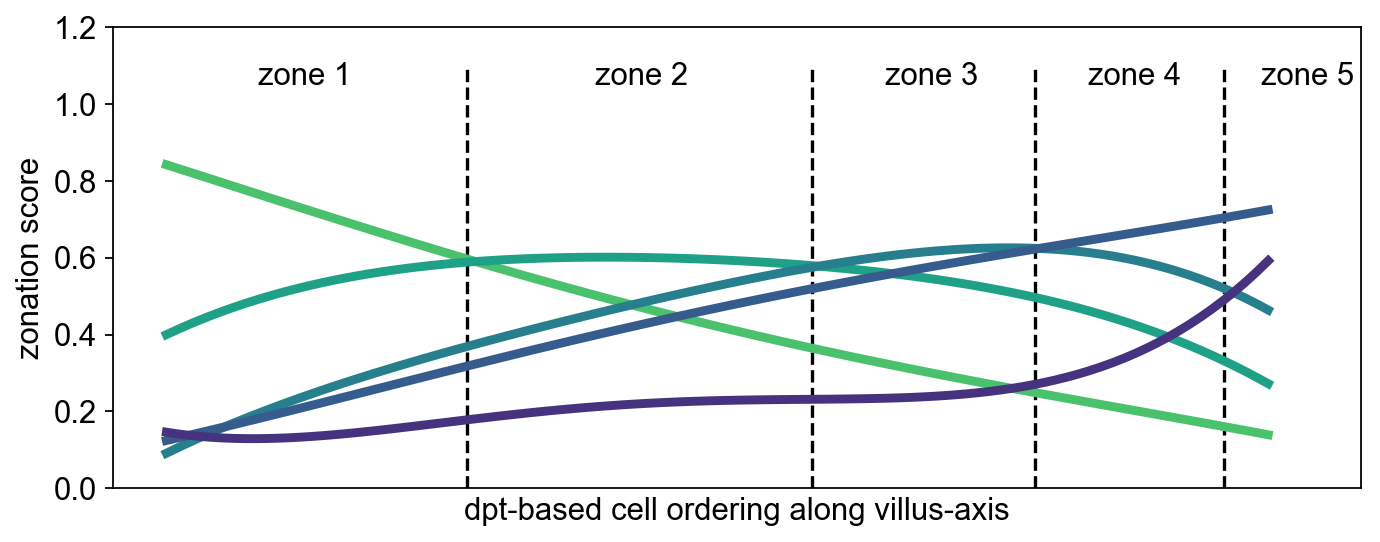

In [177]:
rcParams['figure.figsize'] = ( 10,4)
rcParams['figure.subplot.top'] = 0.85
rcParams['figure.subplot.bottom'] = 0.13

fig,ax=pl.subplots()


sns.regplot(x=df['cell_order'], y=df[df_zon.columns[0]], ax=ax, ci=None, order=4, truncate=True, scatter=False, color=cols[1], line_kws={'linewidth':4})
sns.regplot(x=df['cell_order'], y=df[df_zon.columns[1]], ax=ax, ci=None, order=4, truncate=True, scatter=False, color=cols[2], line_kws={'linewidth':4})
sns.regplot(x=df['cell_order'], y=df[df_zon.columns[2]], ax=ax, ci=None, order=4, truncate=True, scatter=False, color=cols[3], line_kws={'linewidth':4})
sns.regplot(x=df['cell_order'], y=df[df_zon.columns[3]], ax=ax, ci=None, order=4, truncate=True, scatter=False, color=cols[4], line_kws={'linewidth':4})
sns.regplot(x=df['cell_order'], y=df[df_zon.columns[4]], ax=ax, ci=None, order=4, truncate=True, scatter=False, color=cols[5], line_kws={'linewidth':4})

pl.vlines(x=cut_1, ymin=0, ymax=1.1, linestyles='--')
pl.vlines(x=cut_2, ymin=0, ymax=1.1, linestyles='--')
pl.vlines(x=cut_3, ymin=0, ymax=1.1, linestyles='--')
pl.vlines(x=cut_4, ymin=0, ymax=1.1, linestyles='--')

for a,b in zip(['zone 1', 'zone 2', 'zone 3', 'zone 4', 'zone 5'],[180,620,1000,1265,1490]):
    ax.annotate(a, xy=(b, 1.05),  xycoords='data', horizontalalignment = 'center')

ax.set_xticks([])
ax.set_xlim([-70,1560])
ax.set_ylim([0,1.2])

ax.set_xlabel('dpt-based cell ordering along villus-axis')
ax.set_ylabel('zonation score')

pl.grid()
pl.savefig('./figures/dpt_zonation_scores.pdf')
pl.show()

annotate cells by zone

In [69]:
dpt_1 = df['distance'][df.cell_order==int(np.round(cut_1))][0]
dpt_2 = df['distance'][df.cell_order==int(np.round(cut_2))][0]
dpt_3 = df['distance'][df.cell_order==int(np.round(cut_3))][0]
dpt_4 = df['distance'][df.cell_order==int(np.round(cut_4))][0]

In [70]:
adata_ent_zon.obs['zonation'] = ['zone 1' if a <= dpt_1 else 'zone 2' if a <= dpt_2 else 'zone 3' if a <= dpt_3 else 'zone 4' if a <= dpt_4 else 'zone 5' for a in adata_ent_zon.obs.dpt_pseudotime]

... storing 'zonation' as categorical


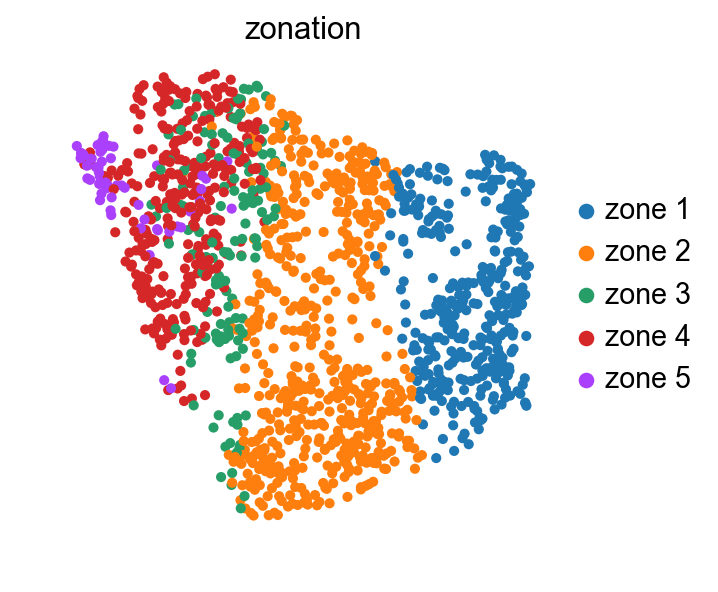

In [71]:
sc.set_figure_params(vector_friendly=True,color_map='viridis',dpi_save=300,transparent=True, frameon=False)
sc.pl.umap(adata_ent_zon, color=['zonation'], ncols=5, color_map='Paired')

#### Differential expression of functional markers along zones in proximal and distal enterocytes

In [74]:
adata_ent.obs['zonation'] = adata_ent_zon.obs.zonation

#### zonation

In [96]:
genes = ['Slc5a1', 'Slc2a2', 'Slc2a5', 'Mgam', 'Sis', 'Lct', 
         'G6pc', 'Fbp1', 'Fbp2', 'Gapdh', 'Pgk1', 'Aldob', 'Pklr', 'Pfkl', 
         'Pkm', 'Ldha', 'Eno1', 'Pfkp', 'Pdk4', 'Slc2a1', 'Pck1',
         'Cyc1', 'Cox5b', 'Cox7b', 'Cox6b1', 'Atp5a1', 'Ndufa1', 'Sdha',
         'Slc43a2', 'Slc7a8', 'Slc1a3', 
         'Fabp1', 'Apoa4', 'Pla2g12a',
         'Slc11a2', 'Fth1', 
         'S100g', 
         'Pdxk', 'Rbp2', 
         'Slc39a11', 'Slc39a7',
         'Slc20a1', 'Slc20a2',
         'Slc36a1', 'Slc7a9', 'Slc36a1', 'Slc16a10', 
         'Slc1a1', 'Slc25a22', 
         'Slc6a8',
         'Slc10a2', 'Fabp6', 
         'Mpst', 'Tst', 'Ethe1', 'Suox', 'Papss1', 
         'Cubn', 'Amn', 
         'Gpx2', 'Gclc', 'Gss', 'Gsr', 'Gsta3', 'Gsta4',
         'Ccl4', 'Ccl5', 'Ccl20', 'Ccl24', 'Nos2']

In [99]:
adata_ent_cd = adata_ent[adata_ent.obs.diet.isin(['CD'])].copy()

In [100]:
adata_ent_hfd = adata_ent[adata_ent.obs.diet.isin(['HFD'])].copy()

In [110]:
adata_ent_cd_prox = adata_ent_cd[adata_ent_cd.obs.regionality.isin(['proximal'])].copy()
adata_ent_cd_dist = adata_ent_cd[adata_ent_cd.obs.regionality.isin(['distal'])].copy()

In [111]:
adata_ent_hfd_prox = adata_ent_hfd[adata_ent_hfd.obs.regionality.isin(['proximal'])].copy()
adata_ent_hfd_dist = adata_ent_hfd[adata_ent_hfd.obs.regionality.isin(['distal'])].copy()

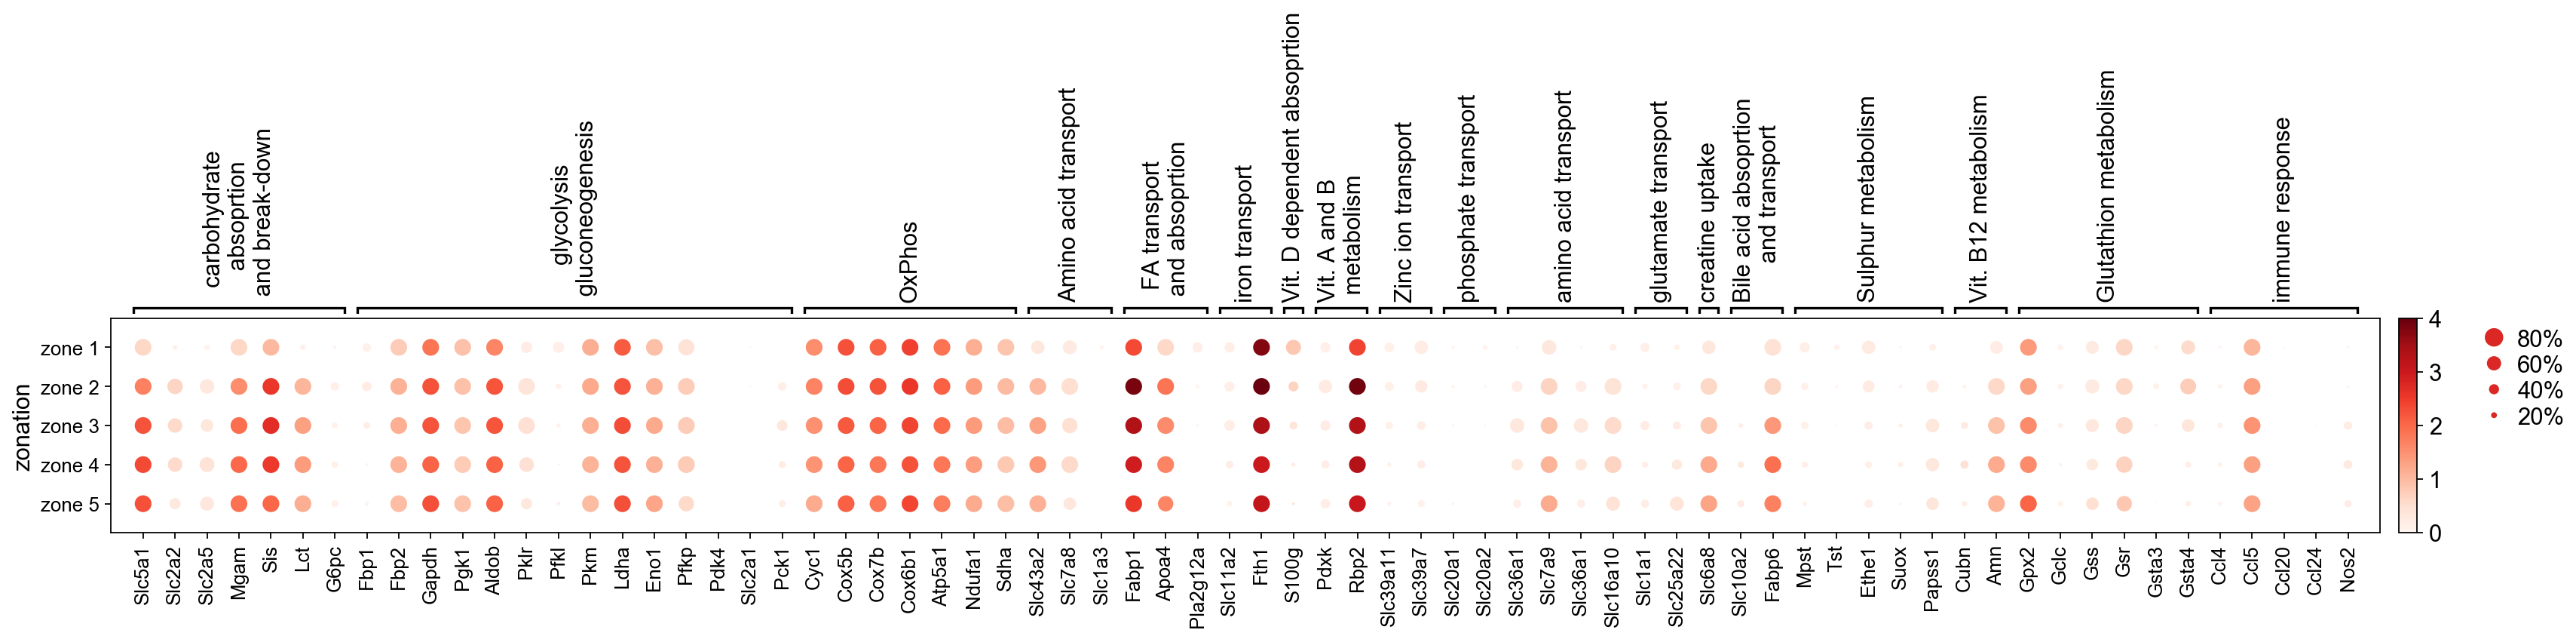

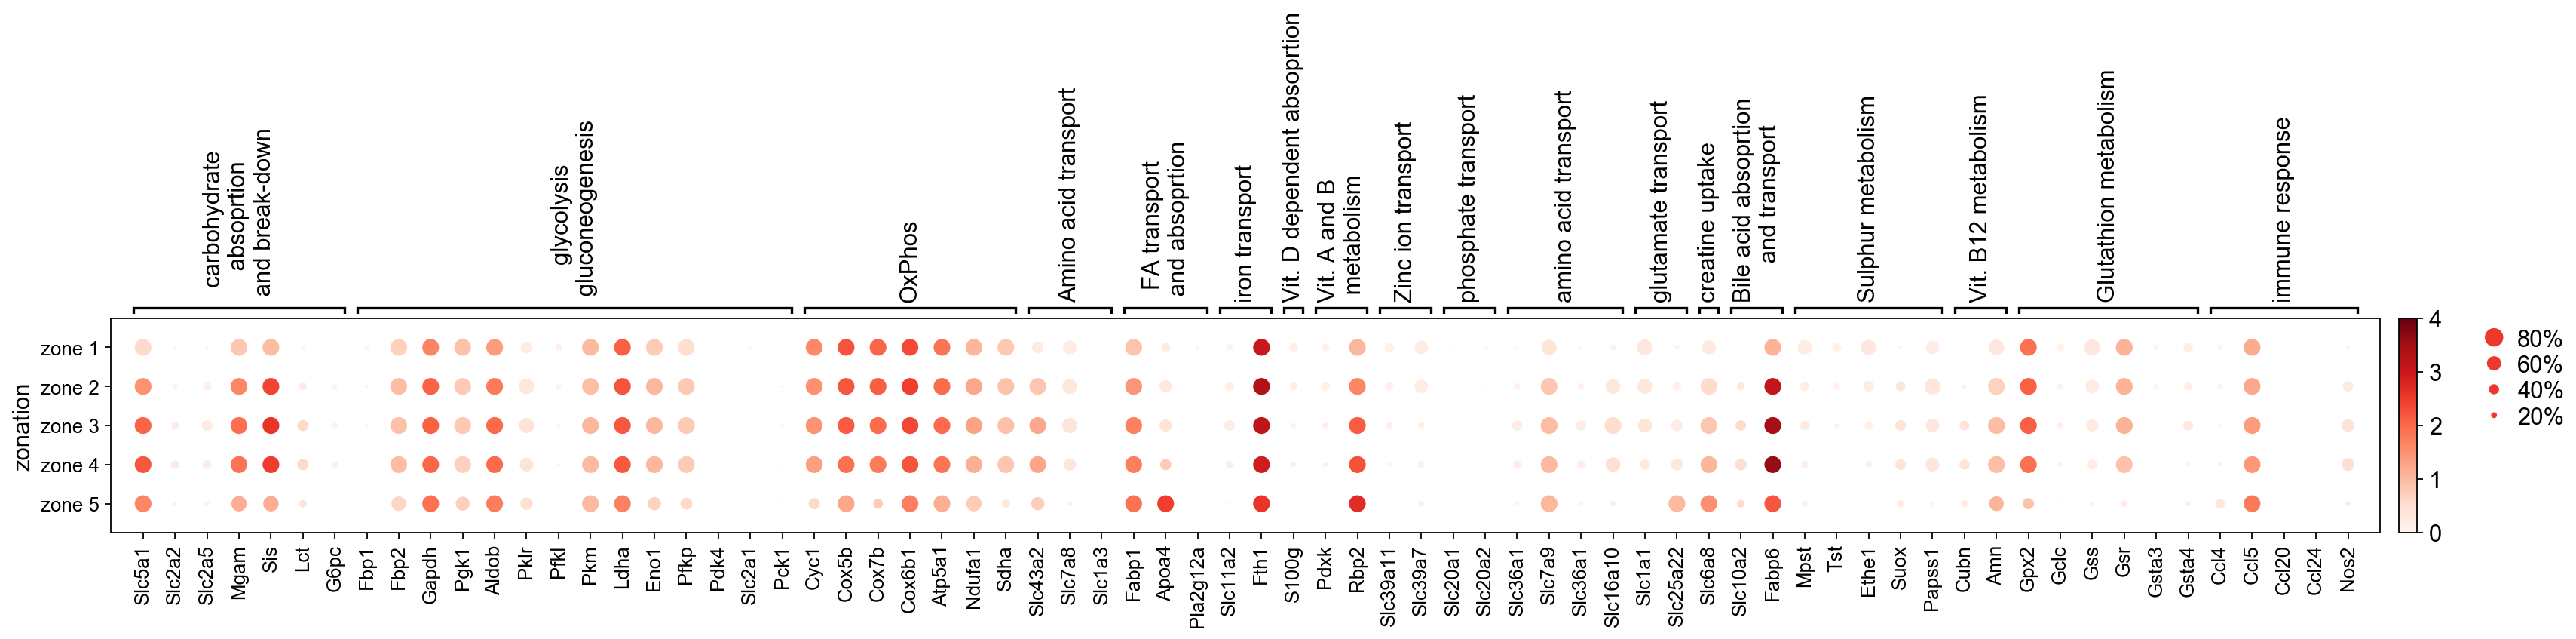

GridSpec(2, 5, height_ratios=[0.5, 10], width_ratios=[24.5, 0, 0.2, 0.5, 0.25])

In [112]:
sc.pl.dotplot(adata_ent_cd_prox, var_names=genes,
              
              var_group_labels=['carbohydrate \n absoprtion \n and break-down', 
                                'glycolysis \n gluconeogenesis', 
                                'OxPhos', 'Amino acid transport', 'FA transport \n and absoprtion', 
                                'iron transport', 
                                'Vit. D dependent absoprtion', 'Vit. A and B \n metabolism', 'Zinc ion transport', 
                                'phosphate transport',
                                'amino acid transport',
                                'glutamate transport',
                                'creatine uptake',
                                'Bile acid absoprtion \n and transport',
                                'Sulphur metabolism', 'Vit. B12 metabolism',
                                'Glutathion metabolism',
                                'immune response'],
              var_group_positions=[(0,6), (7,20), (21,27), (28,30), (31,33), (34,35), (36,36), (37,38), (39,40), 
                                   (41,42), (43,46), (47,48), (49,49), (50,51), (52,56), (57,58), (59, 64), (65, 69)],
              groupby='zonation', dot_max=0.8, vmin=0, vmax=4, save='_enterocytes_zones_all_genes_CD_prox.pdf')

sc.pl.dotplot(adata_ent_cd_dist, var_names=genes,
              
              var_group_labels=['carbohydrate \n absoprtion \n and break-down', 
                                'glycolysis \n gluconeogenesis', 
                                'OxPhos', 'Amino acid transport', 'FA transport \n and absoprtion', 
                                'iron transport', 
                                'Vit. D dependent absoprtion', 'Vit. A and B \n metabolism', 'Zinc ion transport', 
                                'phosphate transport',
                                'amino acid transport',
                                'glutamate transport',
                                'creatine uptake',
                                'Bile acid absoprtion \n and transport',
                                'Sulphur metabolism', 'Vit. B12 metabolism',
                                'Glutathion metabolism',
                                'immune response'],
              var_group_positions=[(0,6), (7,20), (21,27), (28,30), (31,33), (34,35), (36,36), (37,38), (39,40), 
                                   (41,42), (43,46), (47,48), (49,49), (50,51), (52,56), (57,58), (59, 64), (65, 69)],
              groupby='zonation', dot_max=0.8, vmin=0, vmax=4, save='_enterocytes_zones_all_genes_CD_dist.pdf')

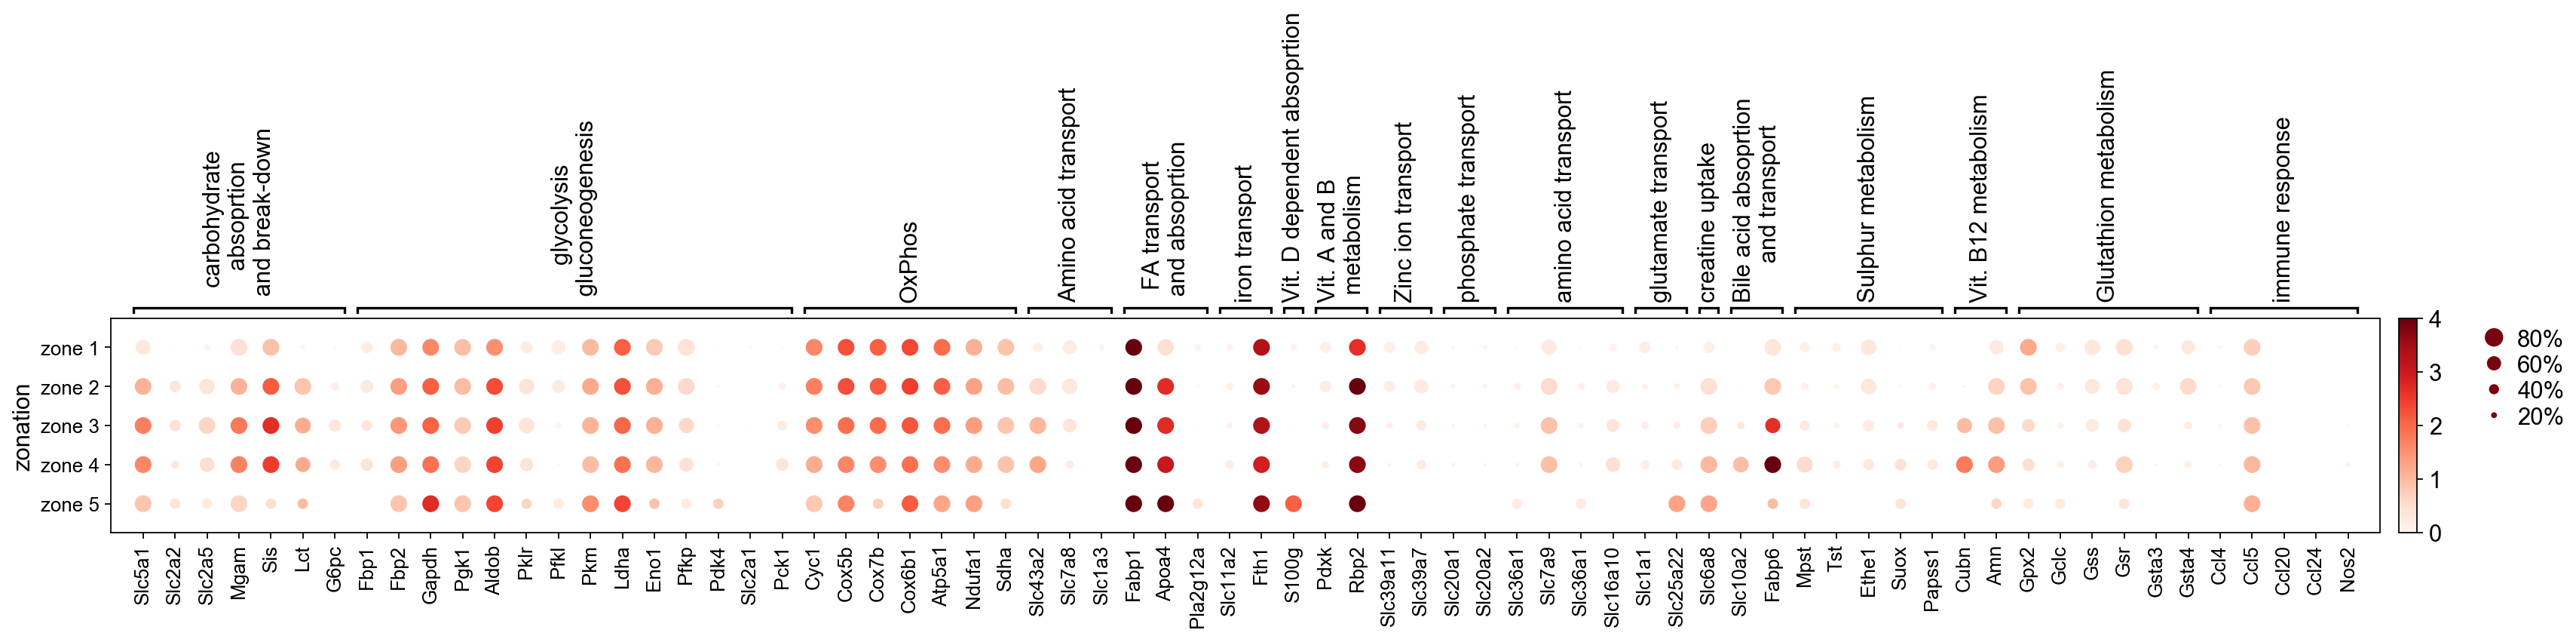

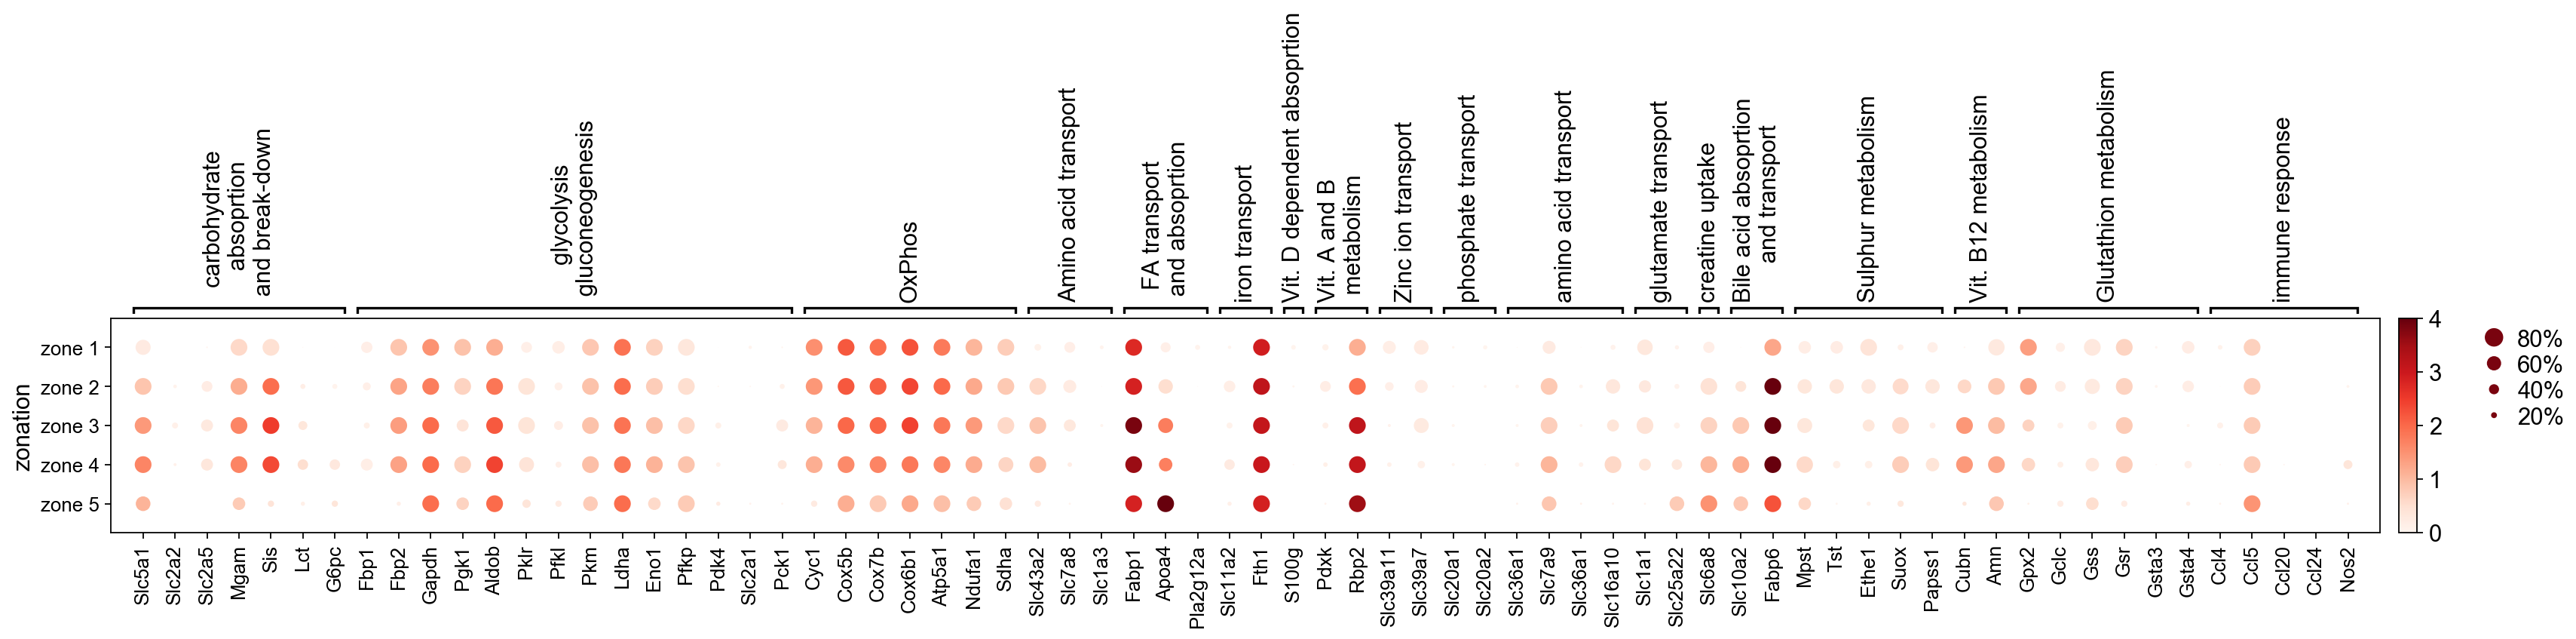

GridSpec(2, 5, height_ratios=[0.5, 10], width_ratios=[24.5, 0, 0.2, 0.5, 0.25])

In [113]:
sc.pl.dotplot(adata_ent_hfd_prox, var_names=genes,
              
              var_group_labels=['carbohydrate \n absoprtion \n and break-down', 
                                'glycolysis \n gluconeogenesis', 
                                'OxPhos', 'Amino acid transport', 'FA transport \n and absoprtion', 
                                'iron transport', 
                                'Vit. D dependent absoprtion', 'Vit. A and B \n metabolism', 'Zinc ion transport', 
                                'phosphate transport',
                                'amino acid transport',
                                'glutamate transport',
                                'creatine uptake',
                                'Bile acid absoprtion \n and transport',
                                'Sulphur metabolism', 'Vit. B12 metabolism',
                                'Glutathion metabolism',
                                'immune response'],
              var_group_positions=[(0,6), (7,20), (21,27), (28,30), (31,33), (34,35), (36,36), (37,38), (39,40), 
                                   (41,42), (43,46), (47,48), (49,49), (50,51), (52,56), (57,58), (59, 64), (65, 69)],
              groupby='zonation', dot_max=0.8, vmin=0, vmax=4, save='_enterocytes_zones_all_genes_HFD_prox.pdf')

sc.pl.dotplot(adata_ent_hfd_dist, var_names=genes,
              
              var_group_labels=['carbohydrate \n absoprtion \n and break-down', 
                                'glycolysis \n gluconeogenesis', 
                                'OxPhos', 'Amino acid transport', 'FA transport \n and absoprtion', 
                                'iron transport', 
                                'Vit. D dependent absoprtion', 'Vit. A and B \n metabolism', 'Zinc ion transport', 
                                'phosphate transport',
                                'amino acid transport',
                                'glutamate transport',
                                'creatine uptake',
                                'Bile acid absoprtion \n and transport',
                                'Sulphur metabolism', 'Vit. B12 metabolism',
                                'Glutathion metabolism',
                                'immune response'],
              var_group_positions=[(0,6), (7,20), (21,27), (28,30), (31,33), (34,35), (36,36), (37,38), (39,40), 
                                   (41,42), (43,46), (47,48), (49,49), (50,51), (52,56), (57,58), (59, 64), (65, 69)],
              groupby='zonation', dot_max=0.8, vmin=0, vmax=4, save='_enterocytes_zones_all_genes_HFD_dist.pdf')